In [1]:

import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torchvision import transforms, models

import time
import copy
import pickle


In [2]:
from resnet_model import Bottleneck, ResNet

In [3]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [4]:
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]

In [5]:
test_idx

array([120, 122])

In [6]:

transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
#     transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

BATCH_SIZE=1

train_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = train_idx,
                                  transform = transform, 
                                  extra_info = True)

val_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = val_idx,
                                  transform = transform, 
                                  extra_info = True)




train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)

In [7]:
test_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = test_idx,
                                  transform = transform, 
                                  extra_info = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [7]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

In [7]:
from VPN_model import PPMBilinear, vpn_model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
encoder = ResNet(Bottleneck, [3, 4, 6, 3],num_classes=4)
# encoder.load_state_dict('pretrained_weights')
encoder = list(encoder.children())[:-3]
encoder = nn.Sequential(*encoder)

decoder = PPMBilinear(fc_dim=1024)
DIM1=  16
DIM2=20
my_model = vpn_model(DIM1, DIM2, encoder, decoder).to(device)

In [13]:
sample, _, roadmap, exta= iter(train_loader).next()
sample = torch.stack(sample).to(device)
roadmap = torch.stack(roadmap).to(device)
output = my_model(sample)


In [15]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [10]:
def tarin_eval_model(model, train_loader, val_loader, criterion, optimizer, 
                     scheduler, num_epochs, checkpoint_file, to_save_path, 
                     batch_size,
                     eval_every = 1000):
    model.train()
    
    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_ts = checkpoint['best_ts']
        print('loading previous weights success')
    else: 
        best_ts = 0.0
    
    
    start_time =time.time()
    
    loss_dict = {'train':[], 'val':[]}
    dice_dict = {'train':[], 'val':[]}

    ts_list = []
    
    curr_iteration = 0
    curr_loss = 0.0
    curr_dice = 0.0
    
    for epoch in range(num_epochs):
        
        train_start  = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        # print('len(train_loader)', len(train_loader.dataset))
        for _, (sample, _, roadmap, _) in enumerate(train_loader):
            sample = torch.stack(sample).to(device)
            target = torch.stack(roadmap).to(device)            

            optimizer.zero_grad()
            outputs = model(sample)
            
            loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
            with torch.no_grad():
                dice = compute_dice(target.cpu(), outputs.cpu().squeeze(1))

            curr_loss += loss.item()
            curr_dice += dice
            
            loss.backward()
            optimizer.step()
            
            curr_iteration +=1
        

            if curr_iteration % eval_every == 0:
                # print(curr_iteration)
                curr_loss/=(curr_iteration*batch_size)
                curr_dice/=(curr_iteration*batch_size)
                
                loss_dict['train'].append(curr_loss)
                dice_dict['train'].append(curr_dice)
        
                print('current training loss is %f'%(curr_loss))
                print('current training dice is %f'%(curr_dice))
                print('training iteration %d takes %f'%(curr_iteration, time.time() - train_start))
                train_start = time.time()
                curr_loss = 0.0
                curr_dice = 0.0
            
                # print('len(val_loader)', len(val_loader.dataset))
                val_start = time.time()
                model.eval()
                
                val_loss = 0.0
                val_dice = 0.0
                curr_ts = 0.0
                total = 0

                with torch.no_grad():
                    for j, (sample, target, roadmap, extra) in enumerate(val_loader):
                        sample = torch.stack(sample).to(device)
                        target = torch.stack(roadmap).to(device)
                        
                        outputs = model(sample)
                        loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
                        dice = compute_dice(target.cpu(), outputs.cpu().squeeze(1))
                        val_loss += loss.item()
                        val_dice += dice
                        curr_ts += compute_ts_road_map(target.cpu(), outputs.cpu().squeeze(1))

                        total += target.size(0)

                curr_ts /= total
                loss_dict['val'].append(val_loss/total)
                dice_dict['val'].append(val_dice/total)
                ts_list.append(curr_ts)
                scheduler.step(curr_ts)

                print('Current validation loss is %f' %(val_loss/total))
                print('Current validation dice is %f'%(val_dice/total))
                print('Current validation ts is %f'%(curr_ts))
                print('current val takes', time.time() - val_start)
                val_start = time.time()

                if curr_ts > best_ts:
                    print('saving best model')
                    best_ts = curr_ts
                    checkpoint = {'model': model.state_dict(), 
                                  'optimizer': optimizer.state_dict(), 
                                  'best_ts': curr_ts}
                    torch.save(checkpoint, to_save_path)

                model.train()
                

    for key in list(loss_dict.keys()):
        if len(loss_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(loss_dict[key])
            plt.title('%s loss per epoch'%(key))
            plt.show()
            
    for key in list(dice_dict.keys()):
        if len(dice_dict[key])>0:
            fig = plt.figure()
            plt.plot(dice_dict[key])
            plt.title('%s dice coef per epoch'%(key))
            plt.show()

        
    if len(ts_list) > 0:
        plt.plot(ts_list)
        plt.title('ts_list')
        plt.show()
    
    return model, loss_dict, dice_dict, ts_list


In [11]:
pretrain_checkpoint = torch.load('/scratch/ht1162/DLResult/pretrain_rotation.pth')

In [12]:
encoder = ResNet(Bottleneck, [3, 4, 6, 3],num_classes=4)
encoder.load_state_dict(pretrain_checkpoint['model'])


<All keys matched successfully>

In [13]:
encoder = list(encoder.children())[:-3]
encoder = nn.Sequential(*encoder)
for param in encoder.parameters():
    param.requires_grad = True
    
decoder = PPMBilinear(fc_dim=1024)
DIM1=  16
DIM2=20
my_model = vpn_model(DIM1, DIM2, encoder, decoder).to(device)

In [14]:
prev_checkpoint = torch.load('/scratch/ht1162/DLResult/self_res50_real4.pth')

In [15]:
my_model.load_state_dict(prev_checkpoint['model'])

<All keys matched successfully>

Epoch 1/3
----------
current training loss is 0.378767
current training dice is 0.310616
training iteration 300 takes 54.659744
Current validation loss is 0.385200
Current validation dice is 0.307400
Current validation ts is 0.448300
current val takes 33.13984751701355
saving best model
current training loss is 0.181229
current training dice is 0.159385
training iteration 600 takes 86.967068
Current validation loss is 0.388666
Current validation dice is 0.305667
Current validation ts is 0.444730
current val takes 29.54368495941162
current training loss is 0.121483
current training dice is 0.105925
training iteration 900 takes 87.810923
Current validation loss is 0.401693
Current validation dice is 0.299153
Current validation ts is 0.434047
current val takes 26.00247836112976
current training loss is 0.087526
current training dice is 0.081237
training iteration 1200 takes 75.899258
Current validation loss is 0.390058
Current validation dice is 0.304971
Current validation ts is 0.443929


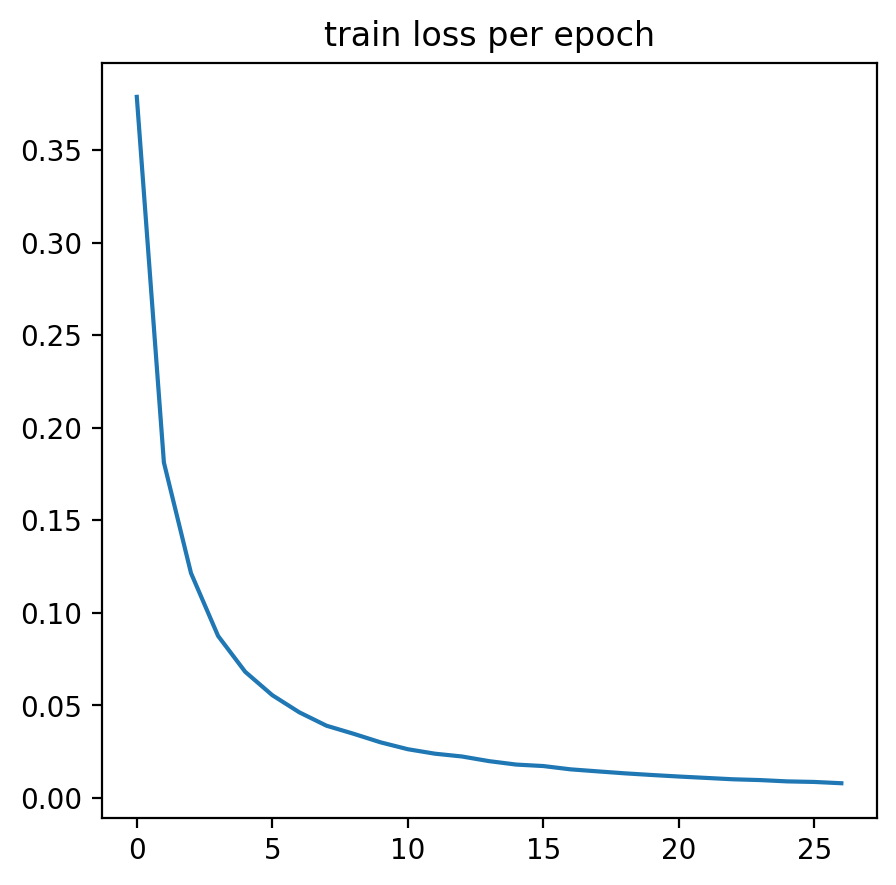

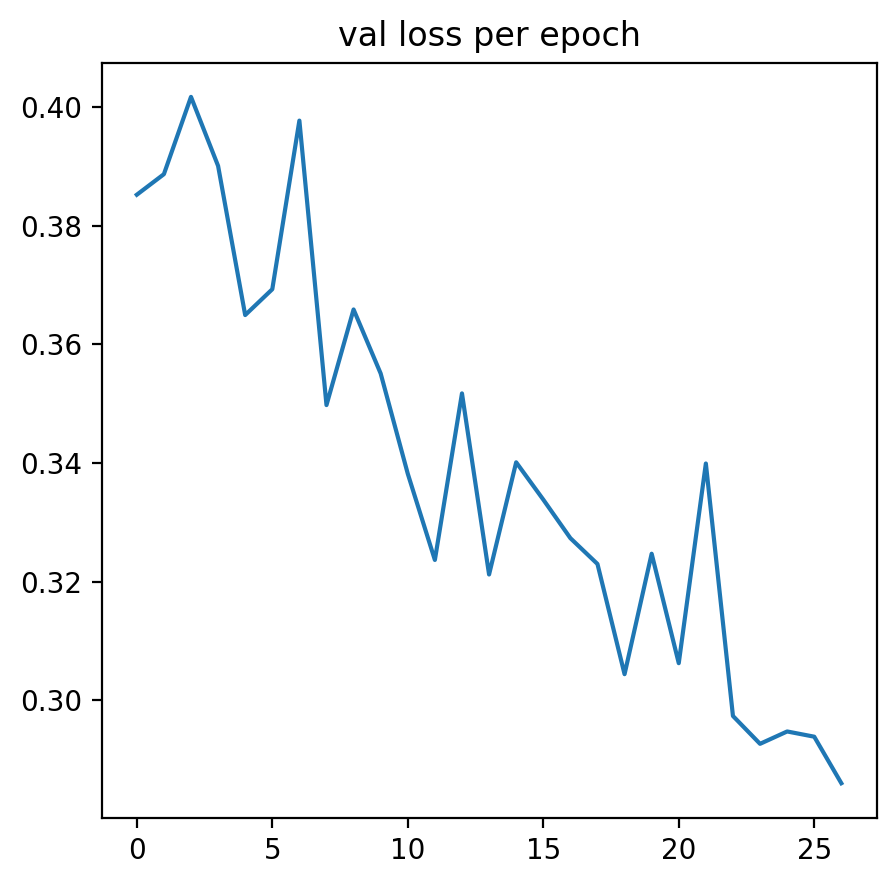

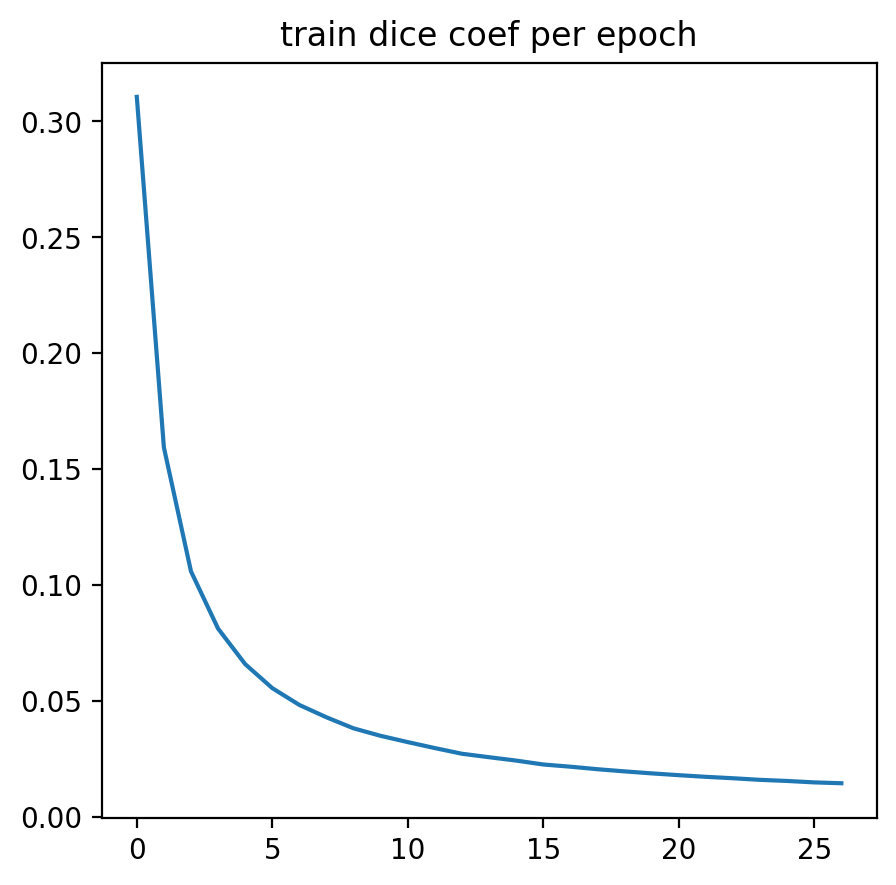

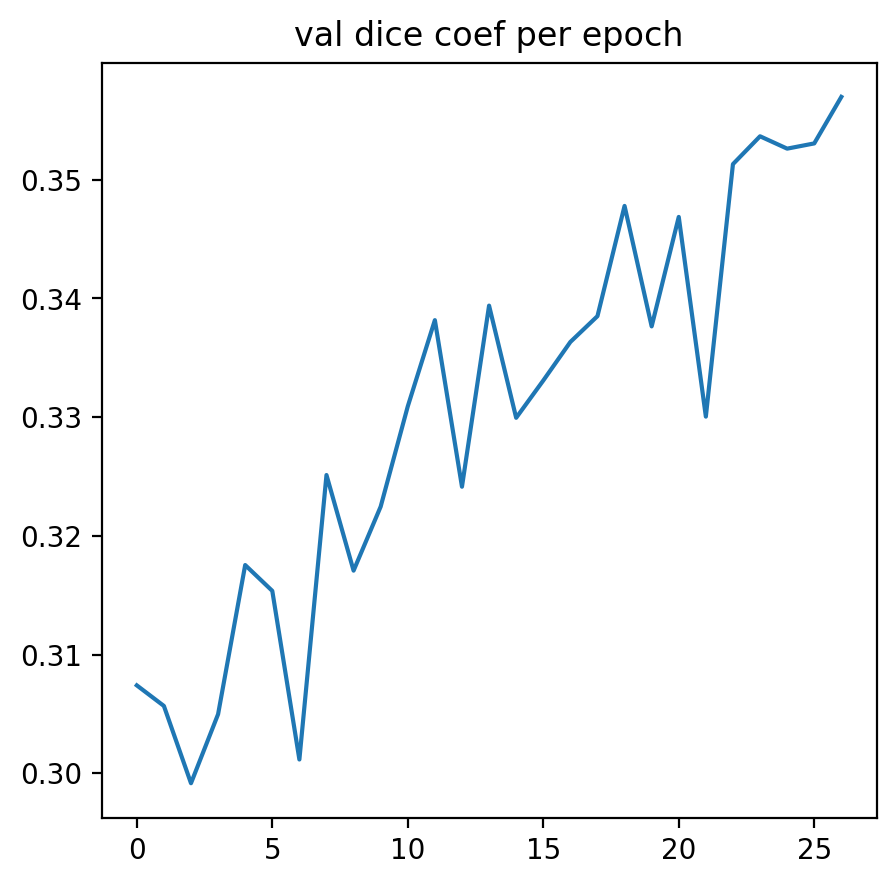

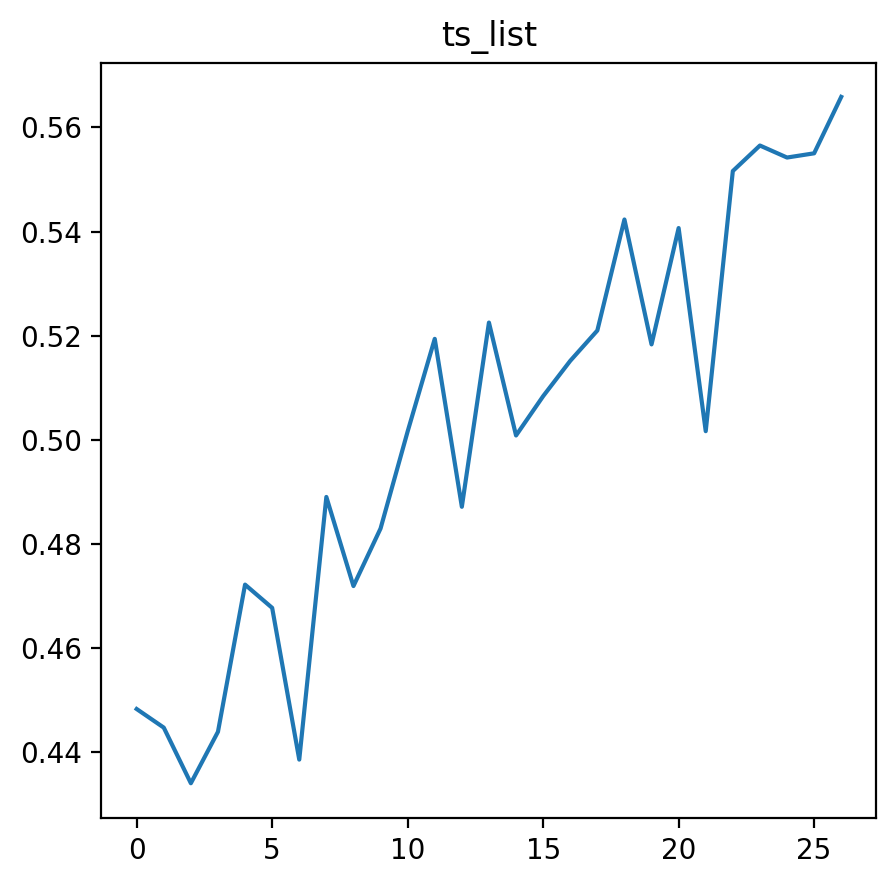

In [45]:
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7, verbose=True)

model, loss_dict, dice_dict, ts_list = tarin_eval_model(my_model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=3, checkpoint_file=None, to_save_path='/scratch/ht1162/DLResult/self_res50_real.pth', 
                     batch_size=1,
                     eval_every = 300)

Epoch 1/3
----------
current training loss is 0.207792
current training dice is 0.396104
training iteration 300 takes 54.001326
Current validation loss is 0.283944
Current validation dice is 0.358028
Current validation ts is 0.567396
current val takes 29.5234591960907
saving best model
current training loss is 0.103354
current training dice is 0.198323
training iteration 600 takes 81.048382
Current validation loss is 0.286681
Current validation dice is 0.356660
Current validation ts is 0.565257
current val takes 27.75436282157898
current training loss is 0.068770
current training dice is 0.132282
training iteration 900 takes 79.032511
Current validation loss is 0.293574
Current validation dice is 0.353213
Current validation ts is 0.556530
current val takes 29.46920657157898
current training loss is 0.050027
current training dice is 0.099986
training iteration 1200 takes 79.918872
Current validation loss is 0.277325
Current validation dice is 0.361338
Current validation ts is 0.577388
c

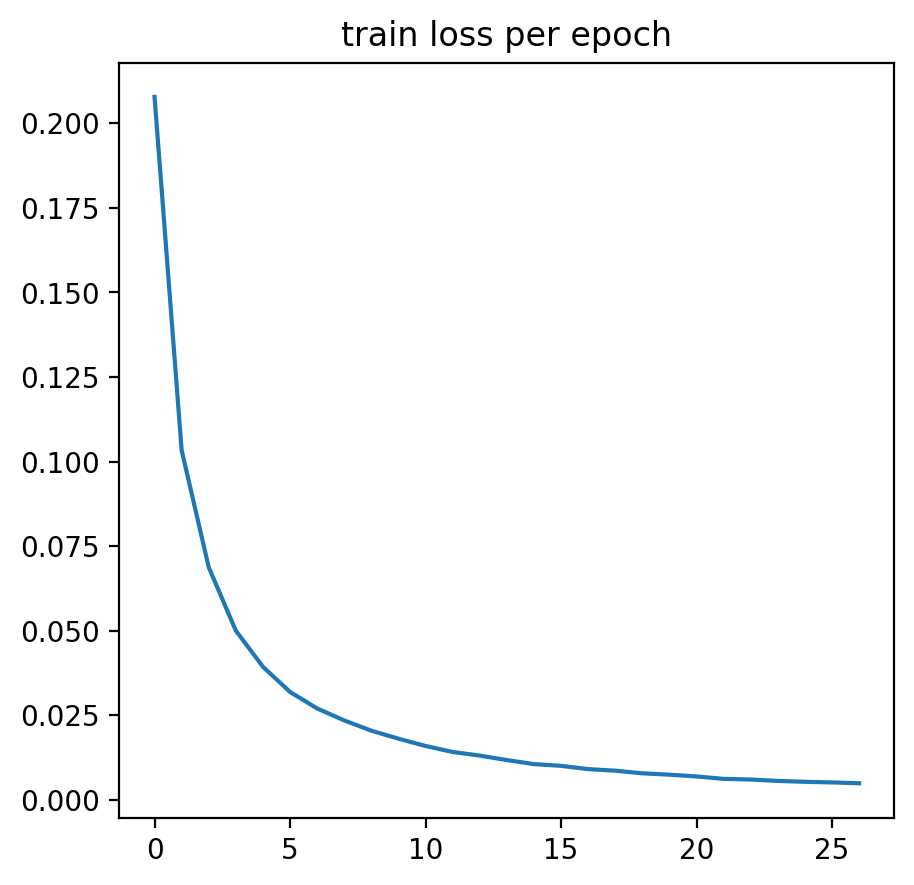

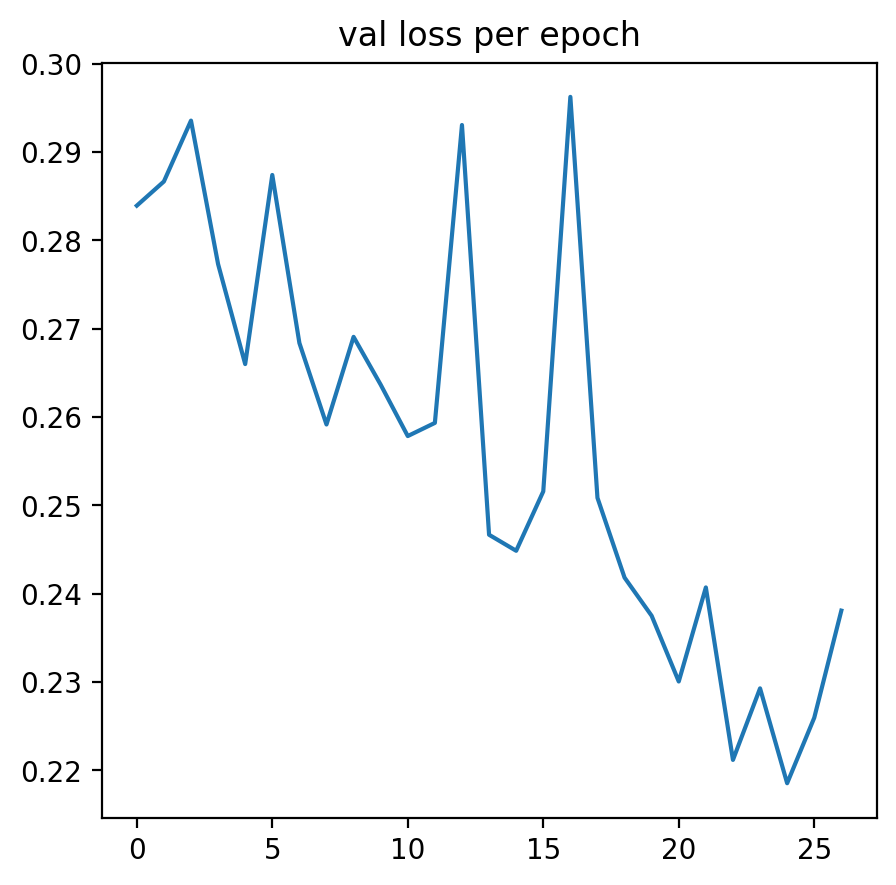

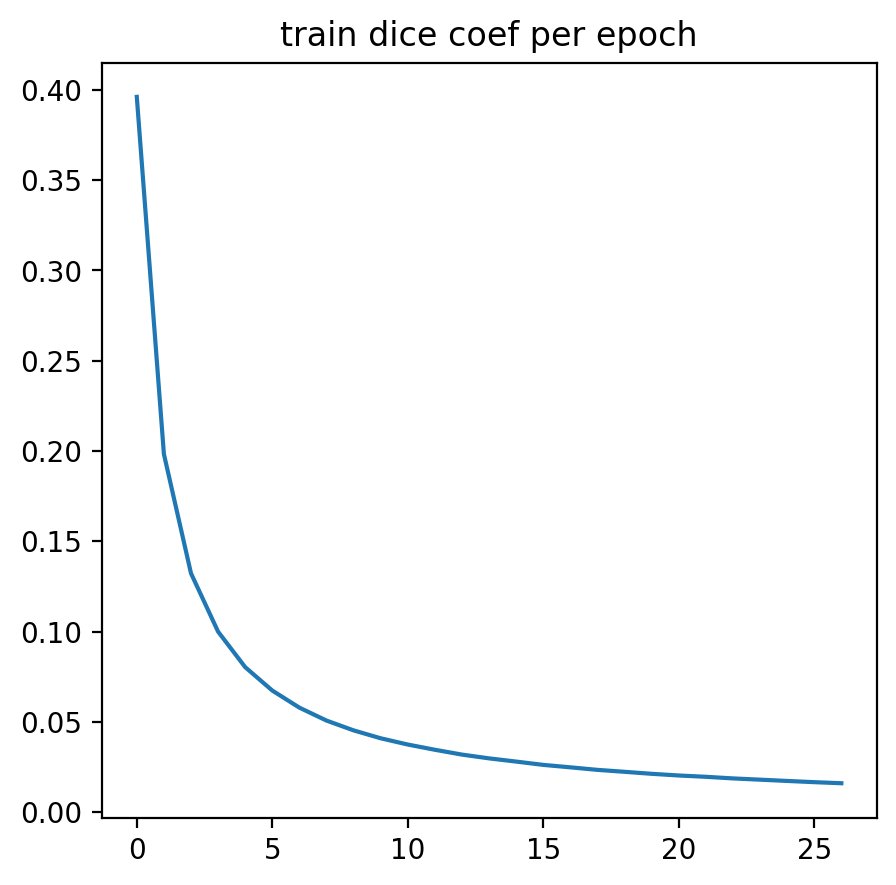

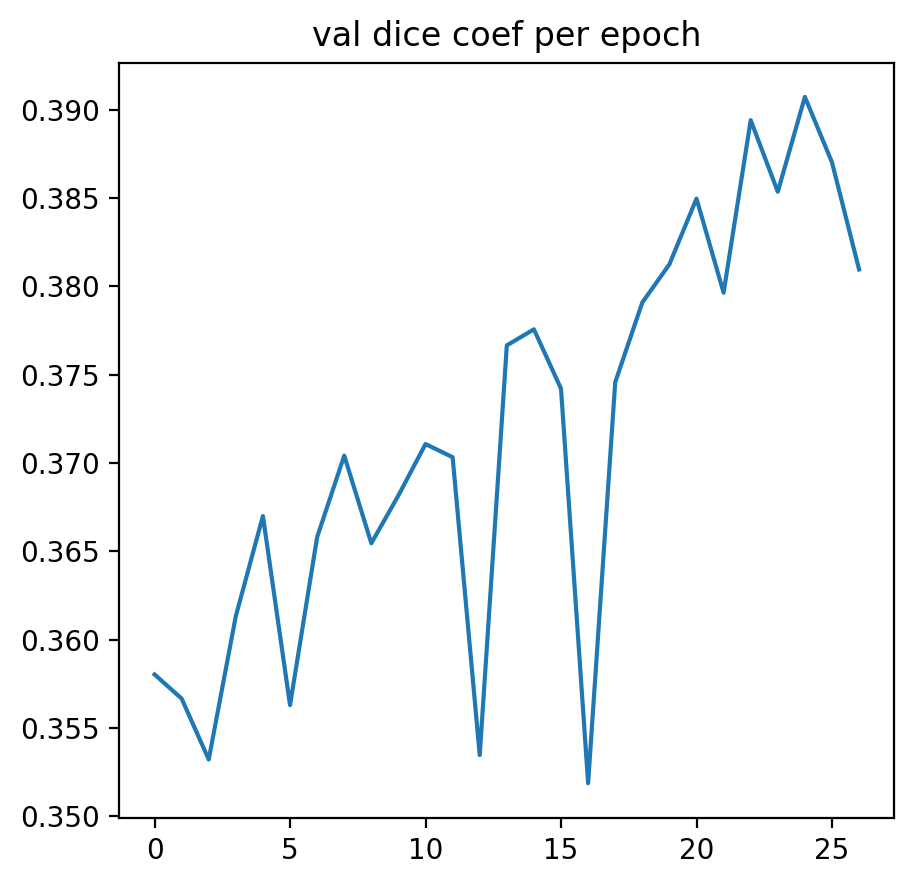

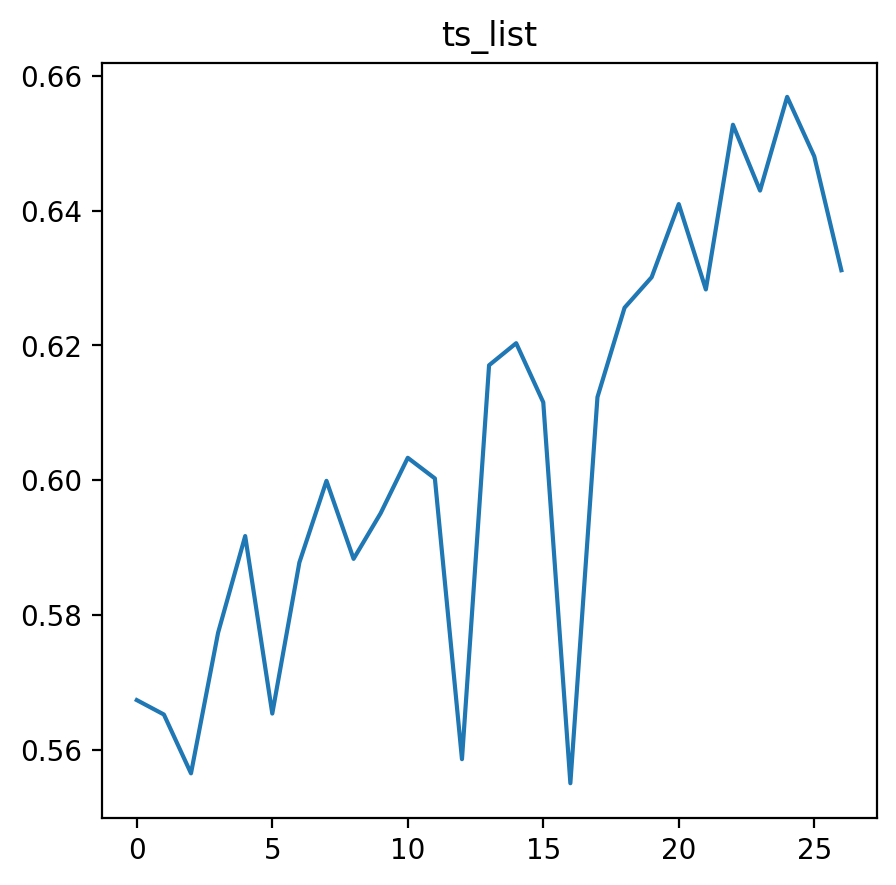

In [46]:
model, loss_dict, dice_dict, ts_list = tarin_eval_model(model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=3, checkpoint_file='/scratch/ht1162/DLResult/self_res50_real.pth', to_save_path='/scratch/ht1162/DLResult/self_res50_real2.pth', 
                     batch_size=1,
                     eval_every = 300)

Epoch 1/5
----------
current training loss is 0.134093
current training dice is 0.432953
training iteration 300 takes 53.113691
Current validation loss is 0.248718
Current validation dice is 0.375641
Current validation ts is 0.616974
current val takes 31.566123008728027
current training loss is 0.065616
current training dice is 0.217192
training iteration 600 takes 82.000290
Current validation loss is 0.217009
Current validation dice is 0.391496
Current validation ts is 0.659365
current val takes 30.308576345443726
saving best model
current training loss is 0.041826
current training dice is 0.145753
training iteration 900 takes 89.239738
Current validation loss is 0.211355
Current validation dice is 0.394323
Current validation ts is 0.667944
current val takes 30.4694881439209
saving best model
current training loss is 0.031053
current training dice is 0.109474
training iteration 1200 takes 88.251063
Current validation loss is 0.209522
Current validation dice is 0.395239
Current validat

current training loss is 0.002314
current training dice is 0.013994
training iteration 9900 takes 83.351395
Current validation loss is 0.193878
Current validation dice is 0.403061
Current validation ts is 0.695639
current val takes 26.764598608016968
current training loss is 0.002232
current training dice is 0.013590
training iteration 10200 takes 81.136009
Current validation loss is 0.188172
Current validation dice is 0.405914
Current validation ts is 0.704261
current val takes 26.052335500717163
current training loss is 0.002221
current training dice is 0.013175
training iteration 10500 takes 84.397103
Current validation loss is 0.175322
Current validation dice is 0.412339
Current validation ts is 0.723762
current val takes 27.605408906936646
saving best model
current training loss is 0.001956
current training dice is 0.012911
training iteration 10800 takes 77.732130
Current validation loss is 0.188861
Current validation dice is 0.405570
Current validation ts is 0.704430
current val 

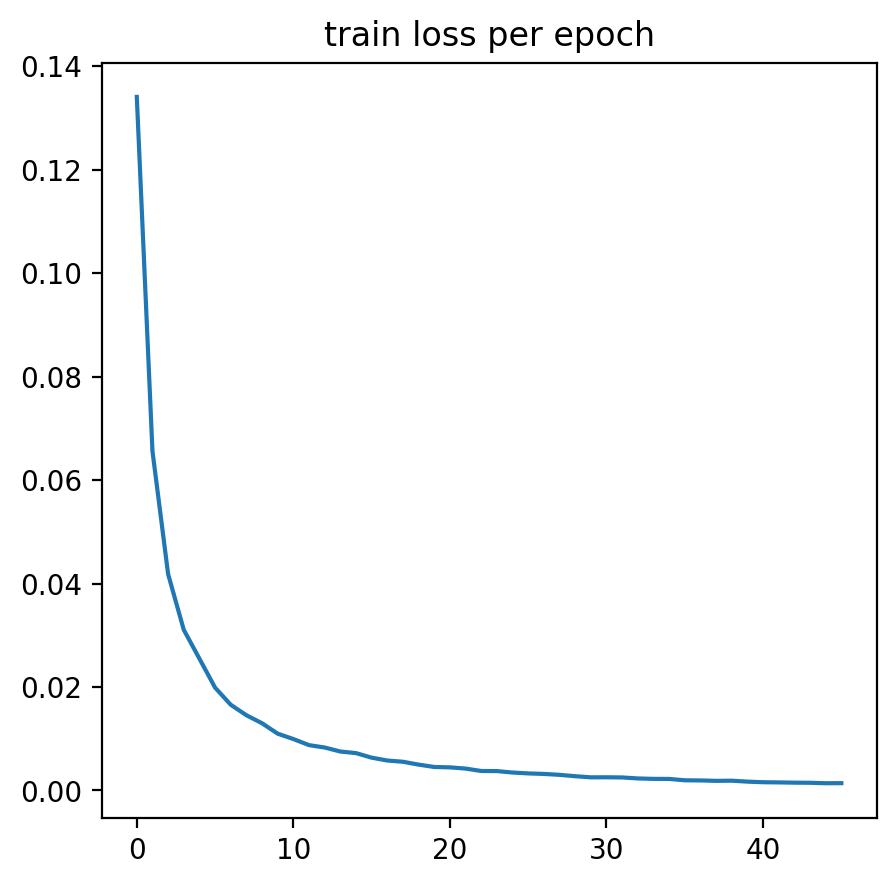

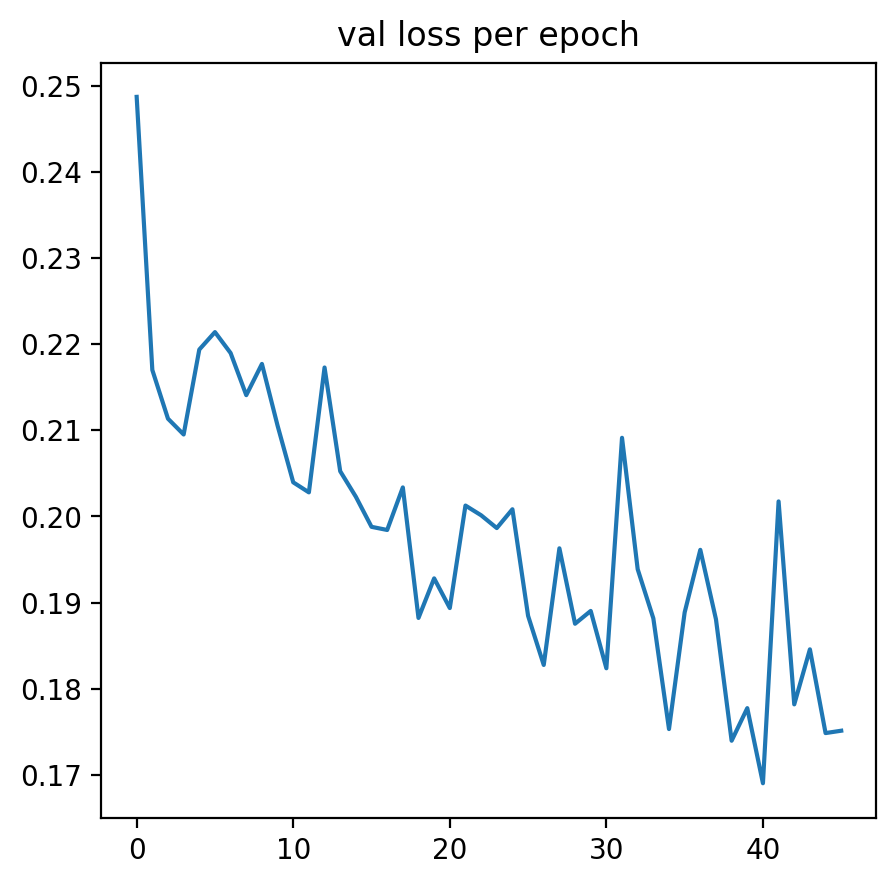

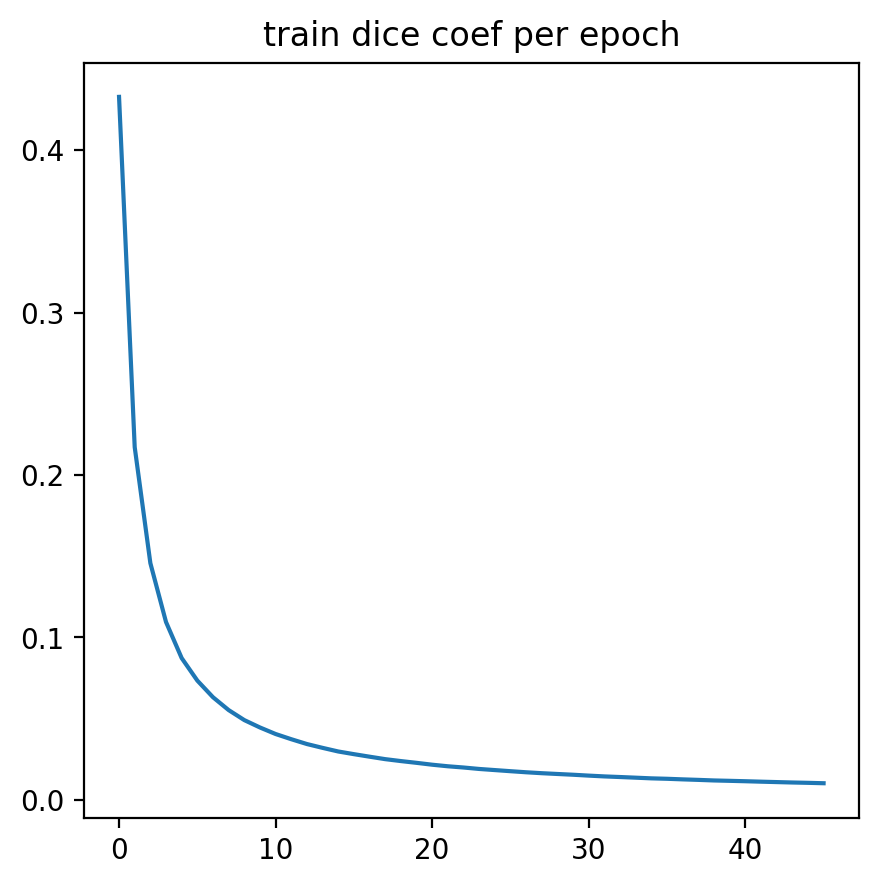

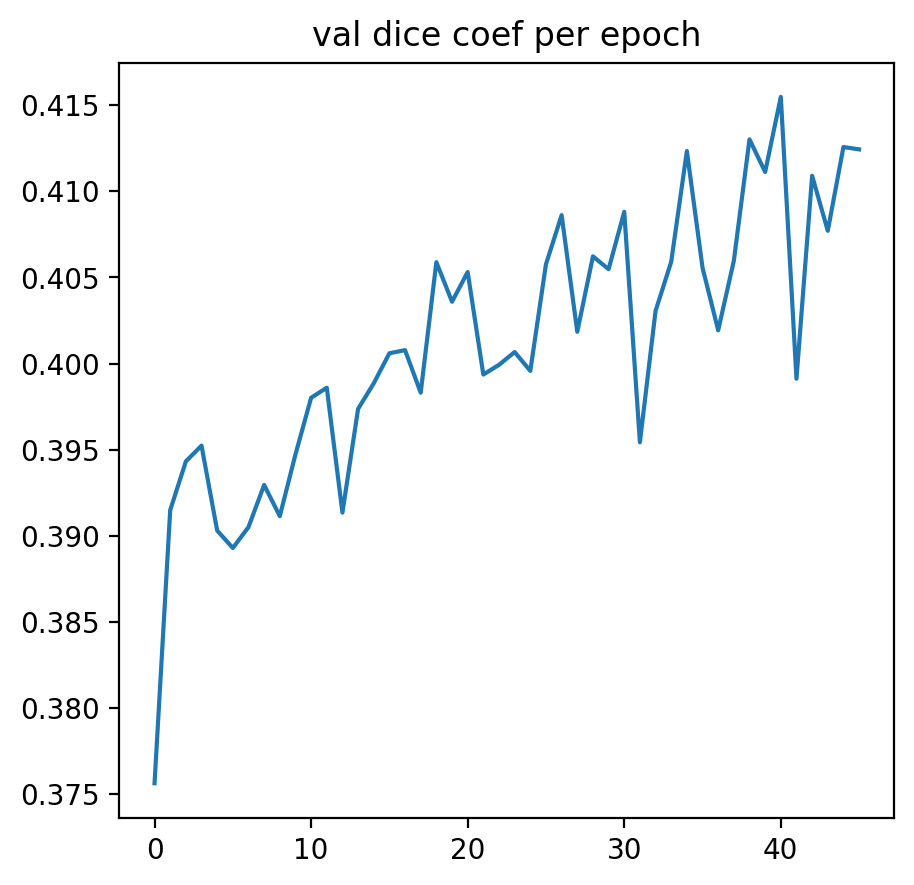

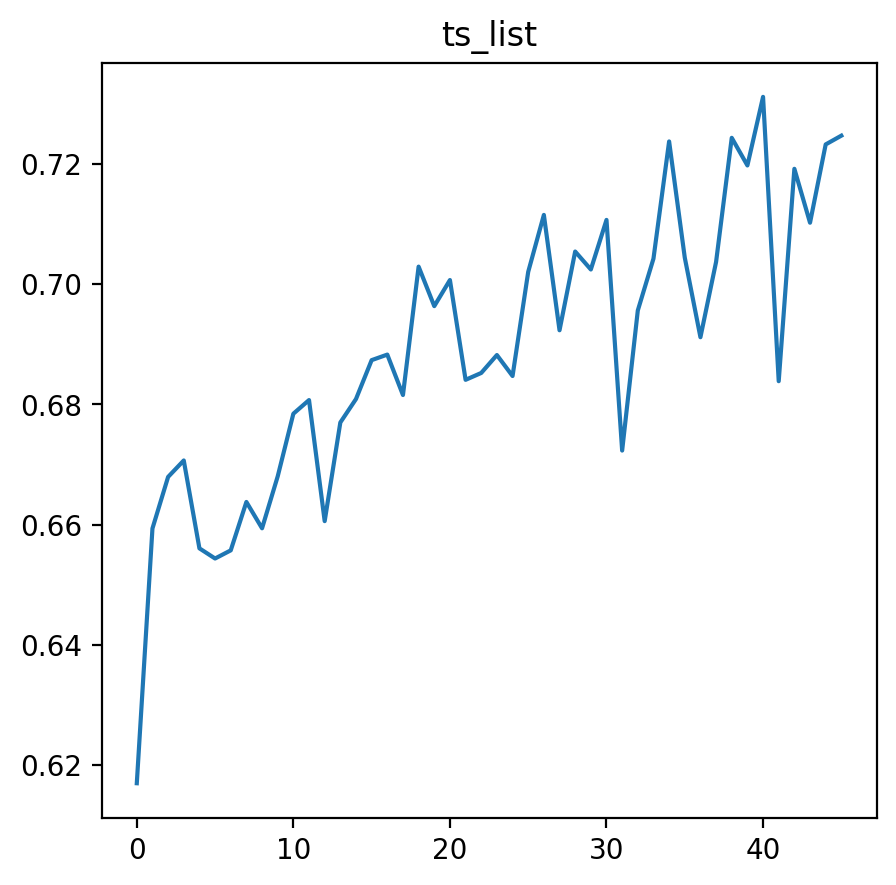

In [47]:
model, loss_dict, dice_dict, ts_list = tarin_eval_model(model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=5, checkpoint_file='/scratch/ht1162/DLResult/self_res50_real2.pth', to_save_path='/scratch/ht1162/DLResult/self_res50_real3.pth', 
                     batch_size=1,
                     eval_every = 300)

Epoch 1/5
----------
current training loss is 0.064291
current training dice is 0.467855
training iteration 300 takes 50.143795
Current validation loss is 0.192145
Current validation dice is 0.403927
Current validation ts is 0.698752
current val takes 29.740085124969482
current training loss is 0.032284
current training dice is 0.233858
training iteration 600 takes 87.231710
Current validation loss is 0.172927
Current validation dice is 0.413536
Current validation ts is 0.726754
current val takes 34.01098704338074
current training loss is 0.021633
current training dice is 0.155850
training iteration 900 takes 92.187104
Current validation loss is 0.167128
Current validation dice is 0.416436
Current validation ts is 0.734760
current val takes 31.07566499710083
saving best model
current training loss is 0.016490
current training dice is 0.116755
training iteration 1200 takes 89.853298
Current validation loss is 0.179898
Current validation dice is 0.410051
Current validation ts is 0.717128

Epoch   133: reducing learning rate of group 0 to 5.0000e-05.
Current validation loss is 0.164041
Current validation dice is 0.417980
Current validation ts is 0.740270
current val takes 29.909261465072632
current training loss is 0.001274
current training dice is 0.014069
training iteration 10200 takes 88.155568
Current validation loss is 0.167149
Current validation dice is 0.416426
Current validation ts is 0.736916
current val takes 26.468535661697388
current training loss is 0.001150
current training dice is 0.013711
training iteration 10500 takes 77.159882
Current validation loss is 0.167718
Current validation dice is 0.416141
Current validation ts is 0.736214
current val takes 25.629979610443115
current training loss is 0.001114
current training dice is 0.013332
training iteration 10800 takes 75.175933
Current validation loss is 0.160904
Current validation dice is 0.419549
Current validation ts is 0.746057
current val takes 27.541752815246582
Epoch 5/5
----------
current training l

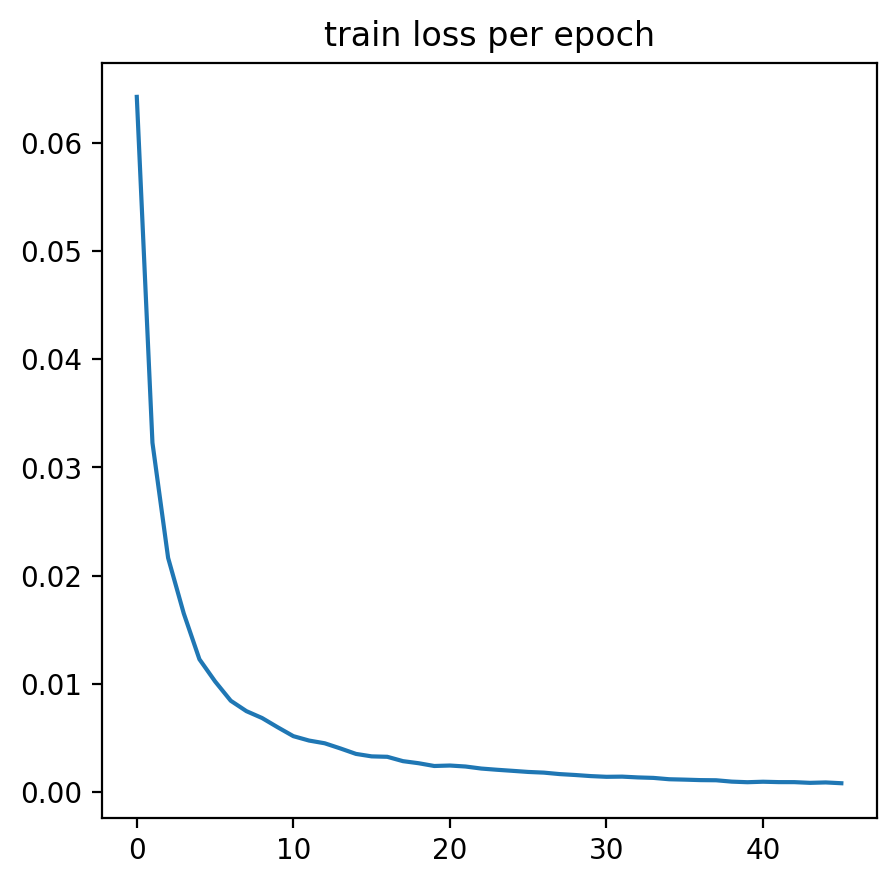

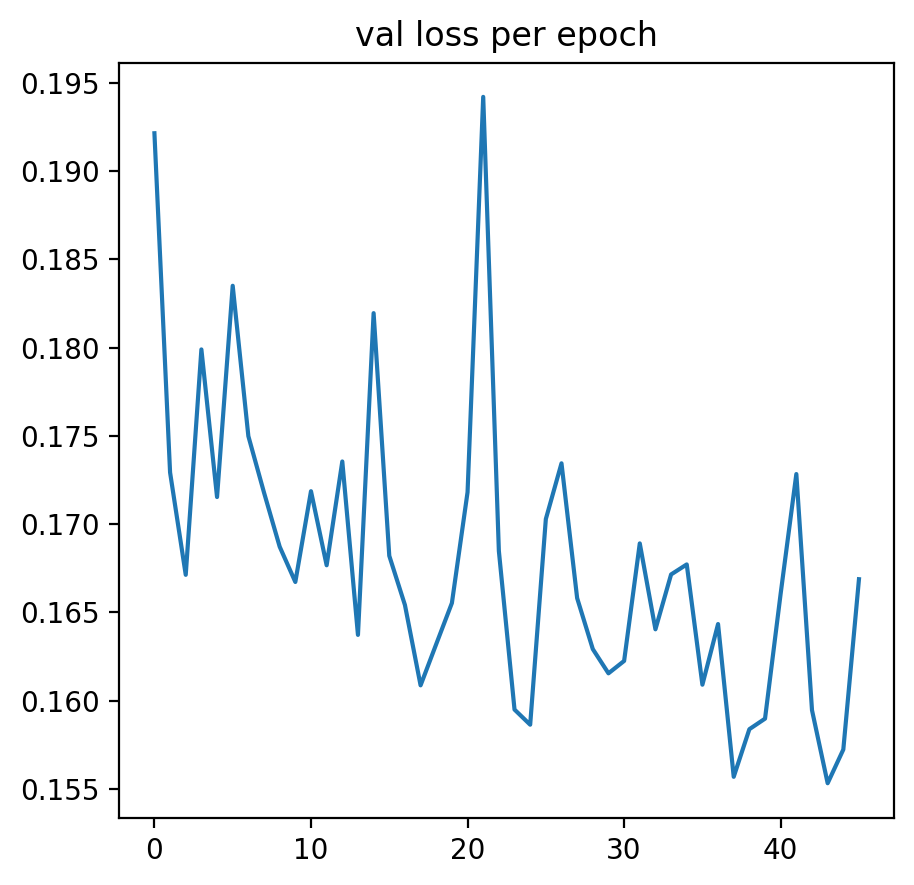

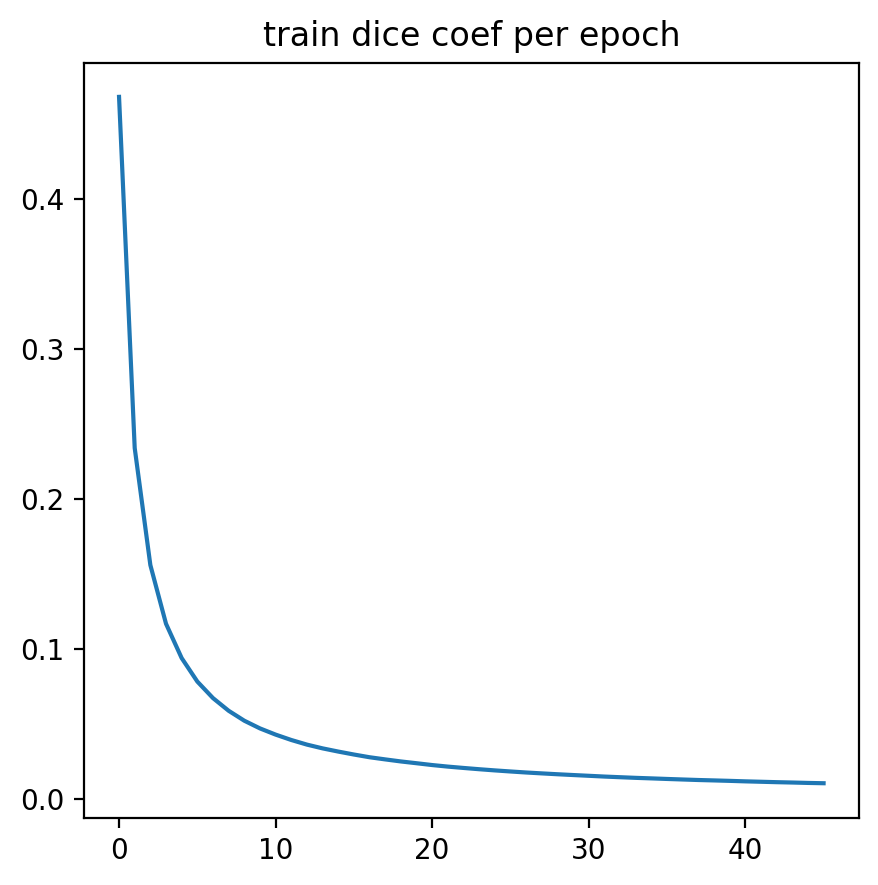

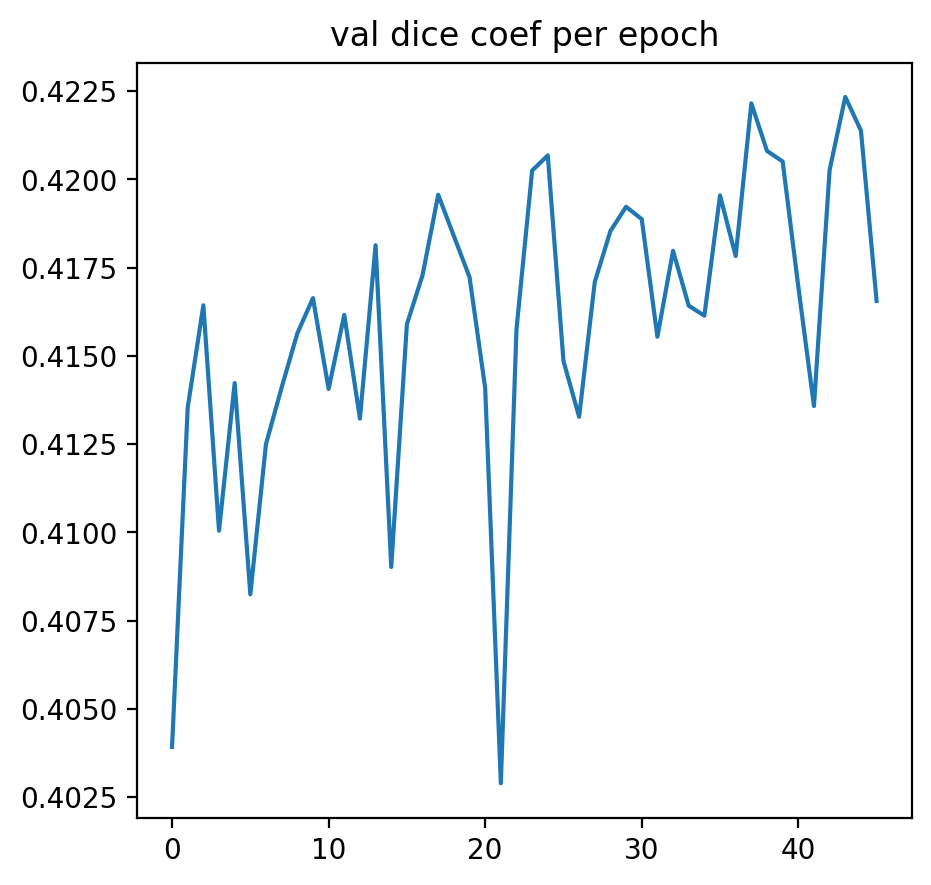

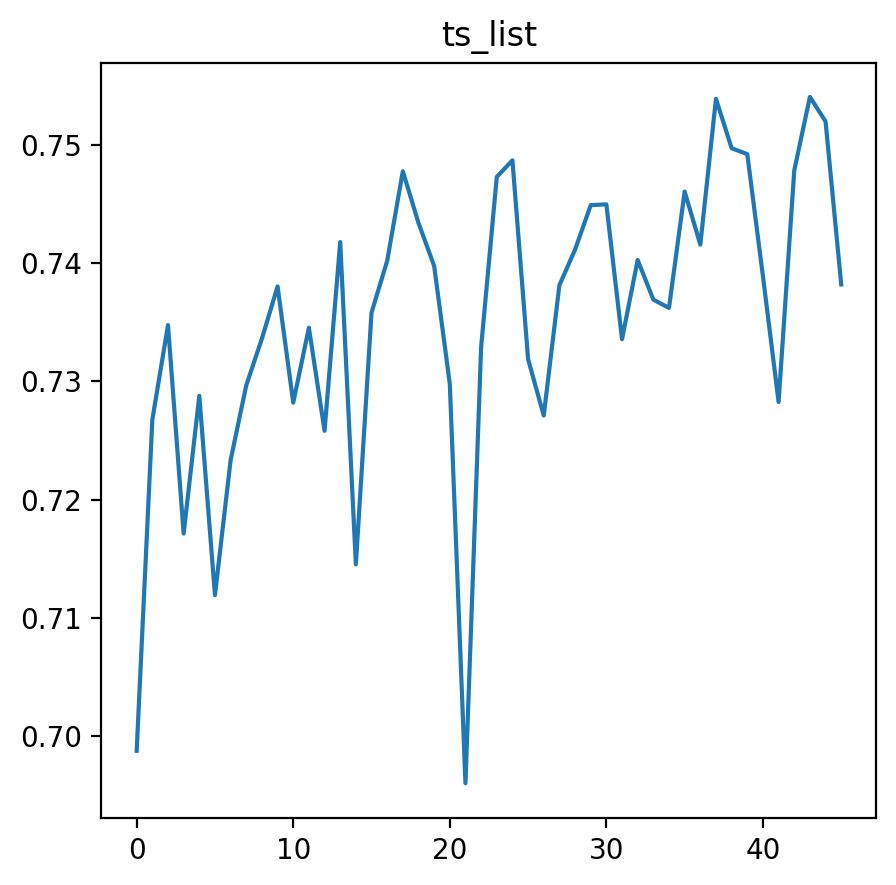

In [48]:
model, loss_dict, dice_dict, ts_list = tarin_eval_model(model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=5, checkpoint_file='/scratch/ht1162/DLResult/self_res50_real3.pth', to_save_path='/scratch/ht1162/DLResult/self_res50_real4.pth', 
                     batch_size=1,
                     eval_every = 300)

In [16]:
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7, verbose=True)

In [17]:
optimizer.load_state_dict(prev_checkpoint['optimizer'])

loading previous weights success
Epoch 1/5
----------
current training loss is 0.034860
current training dice is 0.482570
training iteration 300 takes 56.963652
Current validation loss is 0.157329
Current validation dice is 0.421335
Current validation ts is 0.752278
current val takes 37.310760498046875
current training loss is 0.017914
current training dice is 0.241043
training iteration 600 takes 91.184424
Current validation loss is 0.167743
Current validation dice is 0.416129
Current validation ts is 0.736997
current val takes 45.897595167160034
current training loss is 0.011242
current training dice is 0.161046
training iteration 900 takes 100.436633
Current validation loss is 0.158300
Current validation dice is 0.420850
Current validation ts is 0.750323
current val takes 39.39411687850952
current training loss is 0.008574
current training dice is 0.120713
training iteration 1200 takes 93.304709
Current validation loss is 0.159633
Current validation dice is 0.420184
Current validati

current training loss is 0.000813
current training dice is 0.014745
training iteration 9900 takes 85.264494
Current validation loss is 0.158246
Current validation dice is 0.420877
Current validation ts is 0.750844
current val takes 33.86233878135681
current training loss is 0.000790
current training dice is 0.014311
training iteration 10200 takes 87.987422
Current validation loss is 0.163902
Current validation dice is 0.418049
Current validation ts is 0.742441
current val takes 30.681076288223267
current training loss is 0.000769
current training dice is 0.013901
training iteration 10500 takes 84.973137
Current validation loss is 0.163826
Current validation dice is 0.418087
Current validation ts is 0.742827
current val takes 31.15349841117859
current training loss is 0.000772
current training dice is 0.013503
training iteration 10800 takes 85.065637
Current validation loss is 0.157970
Current validation dice is 0.421015
Current validation ts is 0.750877
current val takes 31.15185165405

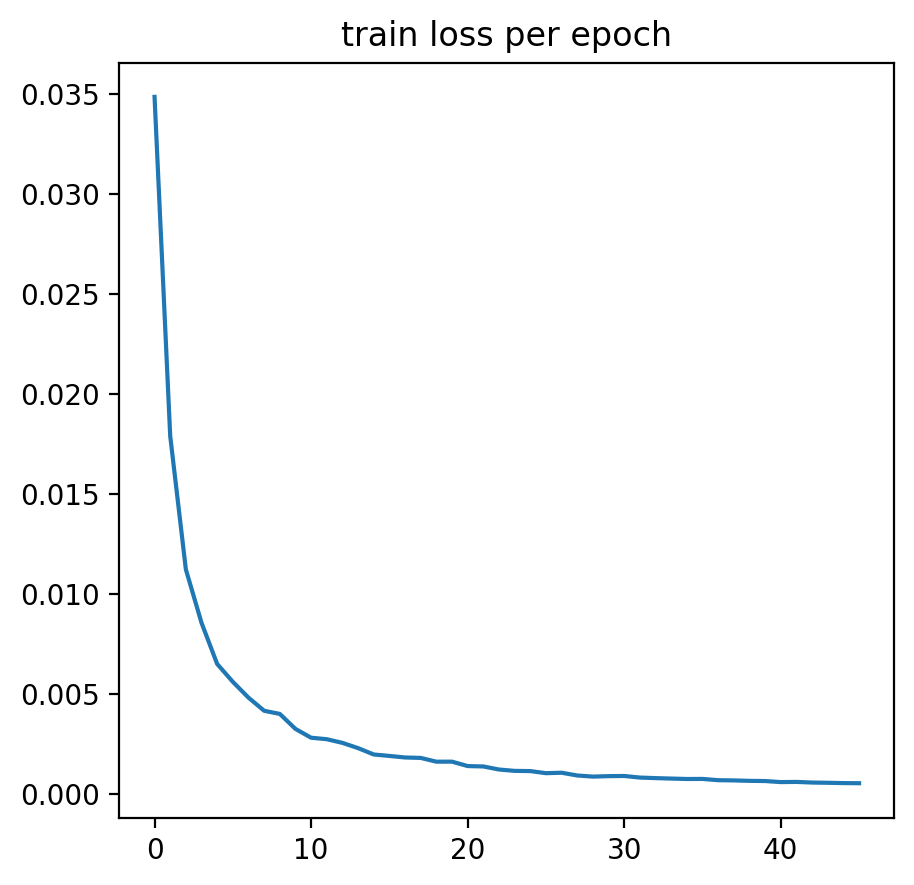

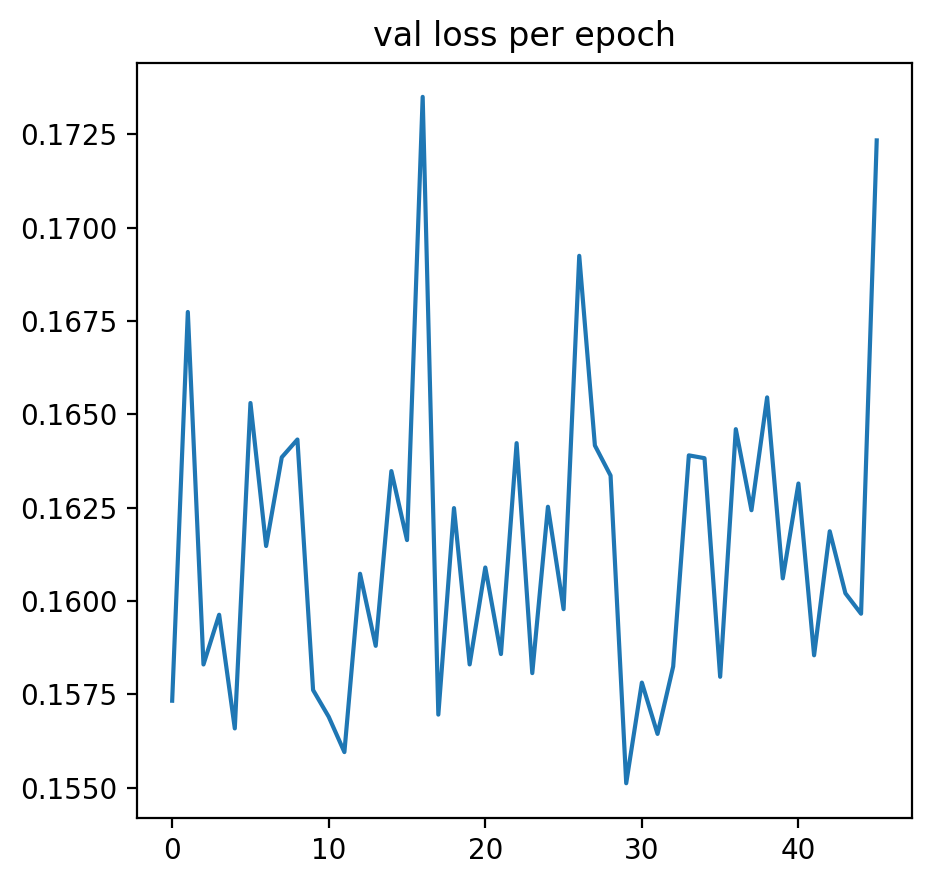

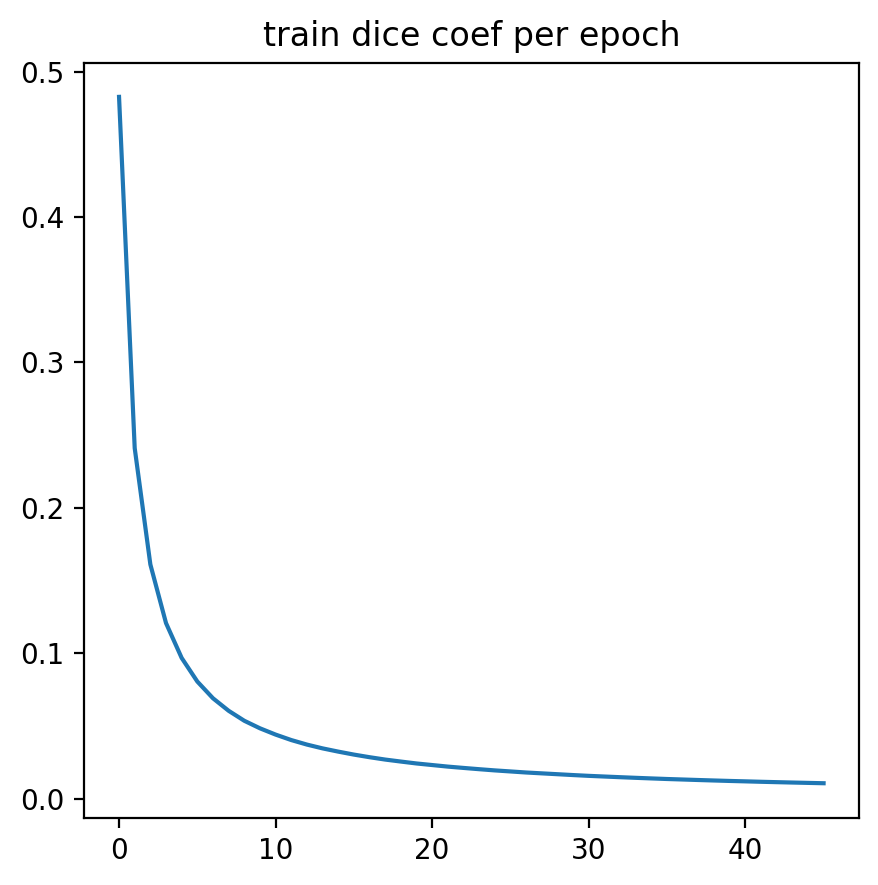

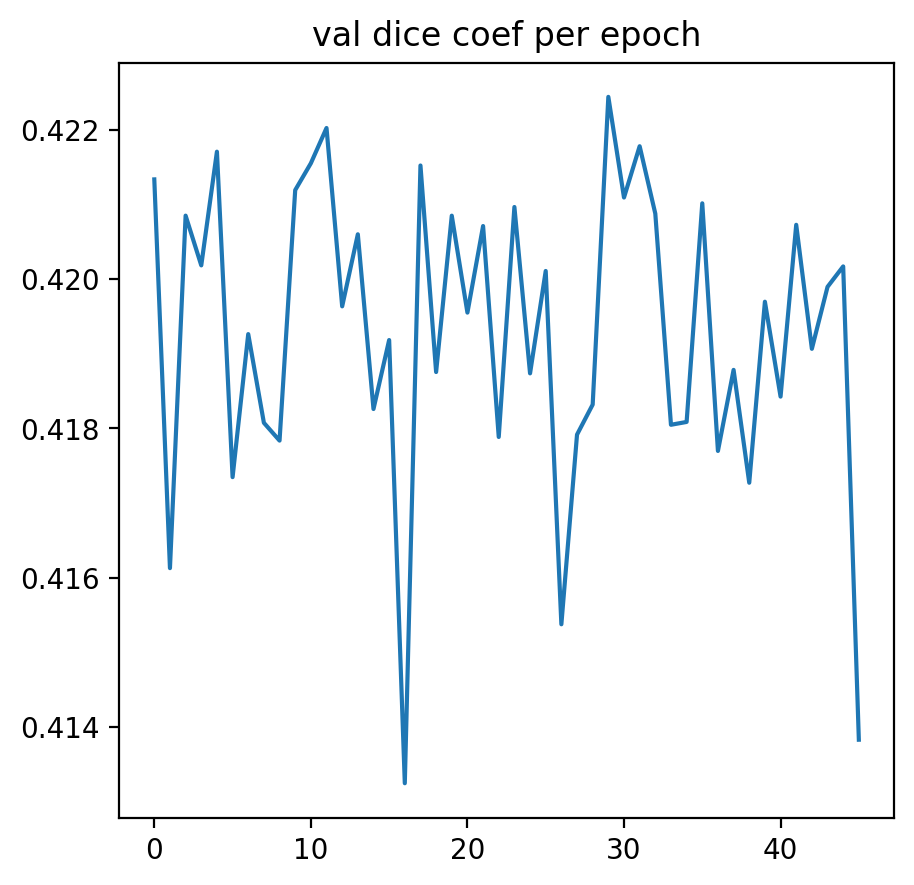

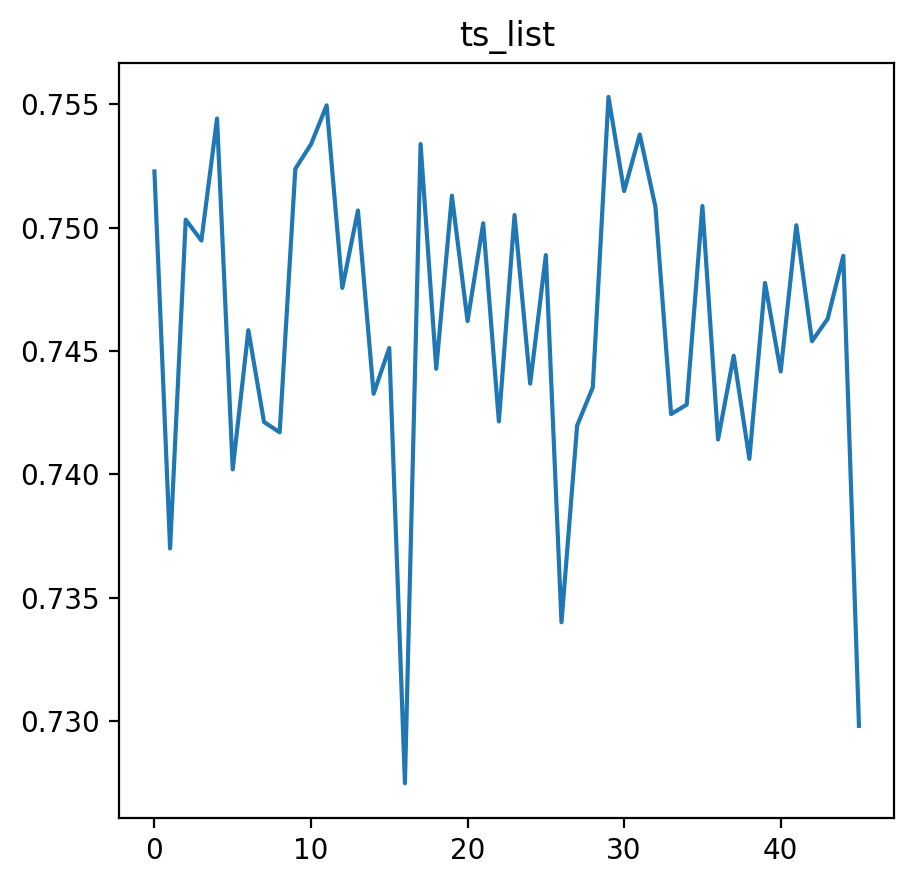

In [18]:
model, loss_dict, dice_dict, ts_list = tarin_eval_model(my_model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=5, checkpoint_file='/scratch/ht1162/DLResult/self_res50_real5.pth', to_save_path='/scratch/ht1162/DLResult/self_res50_real5.pth', 
                     batch_size=1,
                     eval_every = 300)

In [30]:
def eval_model(model, test_loader):
    curr_ts = 0
    for i, (data, _, road, _) in enumerate(test_loader):
        with torch.no_grad():
            data = torch.stack(data).to(device)
            target = torch.stack(road).to(device)
            outputs = model(data)
            curr_ts += compute_ts_road_map(target.cpu(), outputs.cpu().squeeze(1))
            
    print('current ts for test dataset is '%(curr_ts/len(test_loader.dataset)))
    return curr_ts/len(test_loader.dataset)

In [34]:
resnet_encoder = torchvision.models.resnet18(pretrained = False)
resnet_encoder = list(resnet_encoder.children())[:-3]
resnet_encoder = nn.Sequential(*resnet_encoder)

resnet_encoder = resnet_encoder

DIM1 = 16
DIM2 = 20
decoder = PPMBilinear(fc_dim=256)

my_model = vpn_model(DIM1, DIM2, resnet_encoder, decoder)

In [44]:
my_model.load_state_dict(torch.load('/scratch/ht1162/DLSP20Dataset/vpn_model_v3.pth'))
my_model = my_model.cuda()

In [23]:
prev_checkpoint = torch.load('/scratch/ht1162/DLResult/self_res50_real5.pth')
test_encoder = list(encoder.children())[:-3]
test_encoder = nn.Sequential(*encoder)
for param in test_encoder.parameters():
    param.requires_grad = True
    
test_decoder = PPMBilinear(fc_dim=1024)
DIM1=  16
DIM2=20
test_model = vpn_model(DIM1, DIM2, test_encoder, test_decoder).to(device)
test_model.load_state_dict(prev_checkpoint['model'])

<All keys matched successfully>

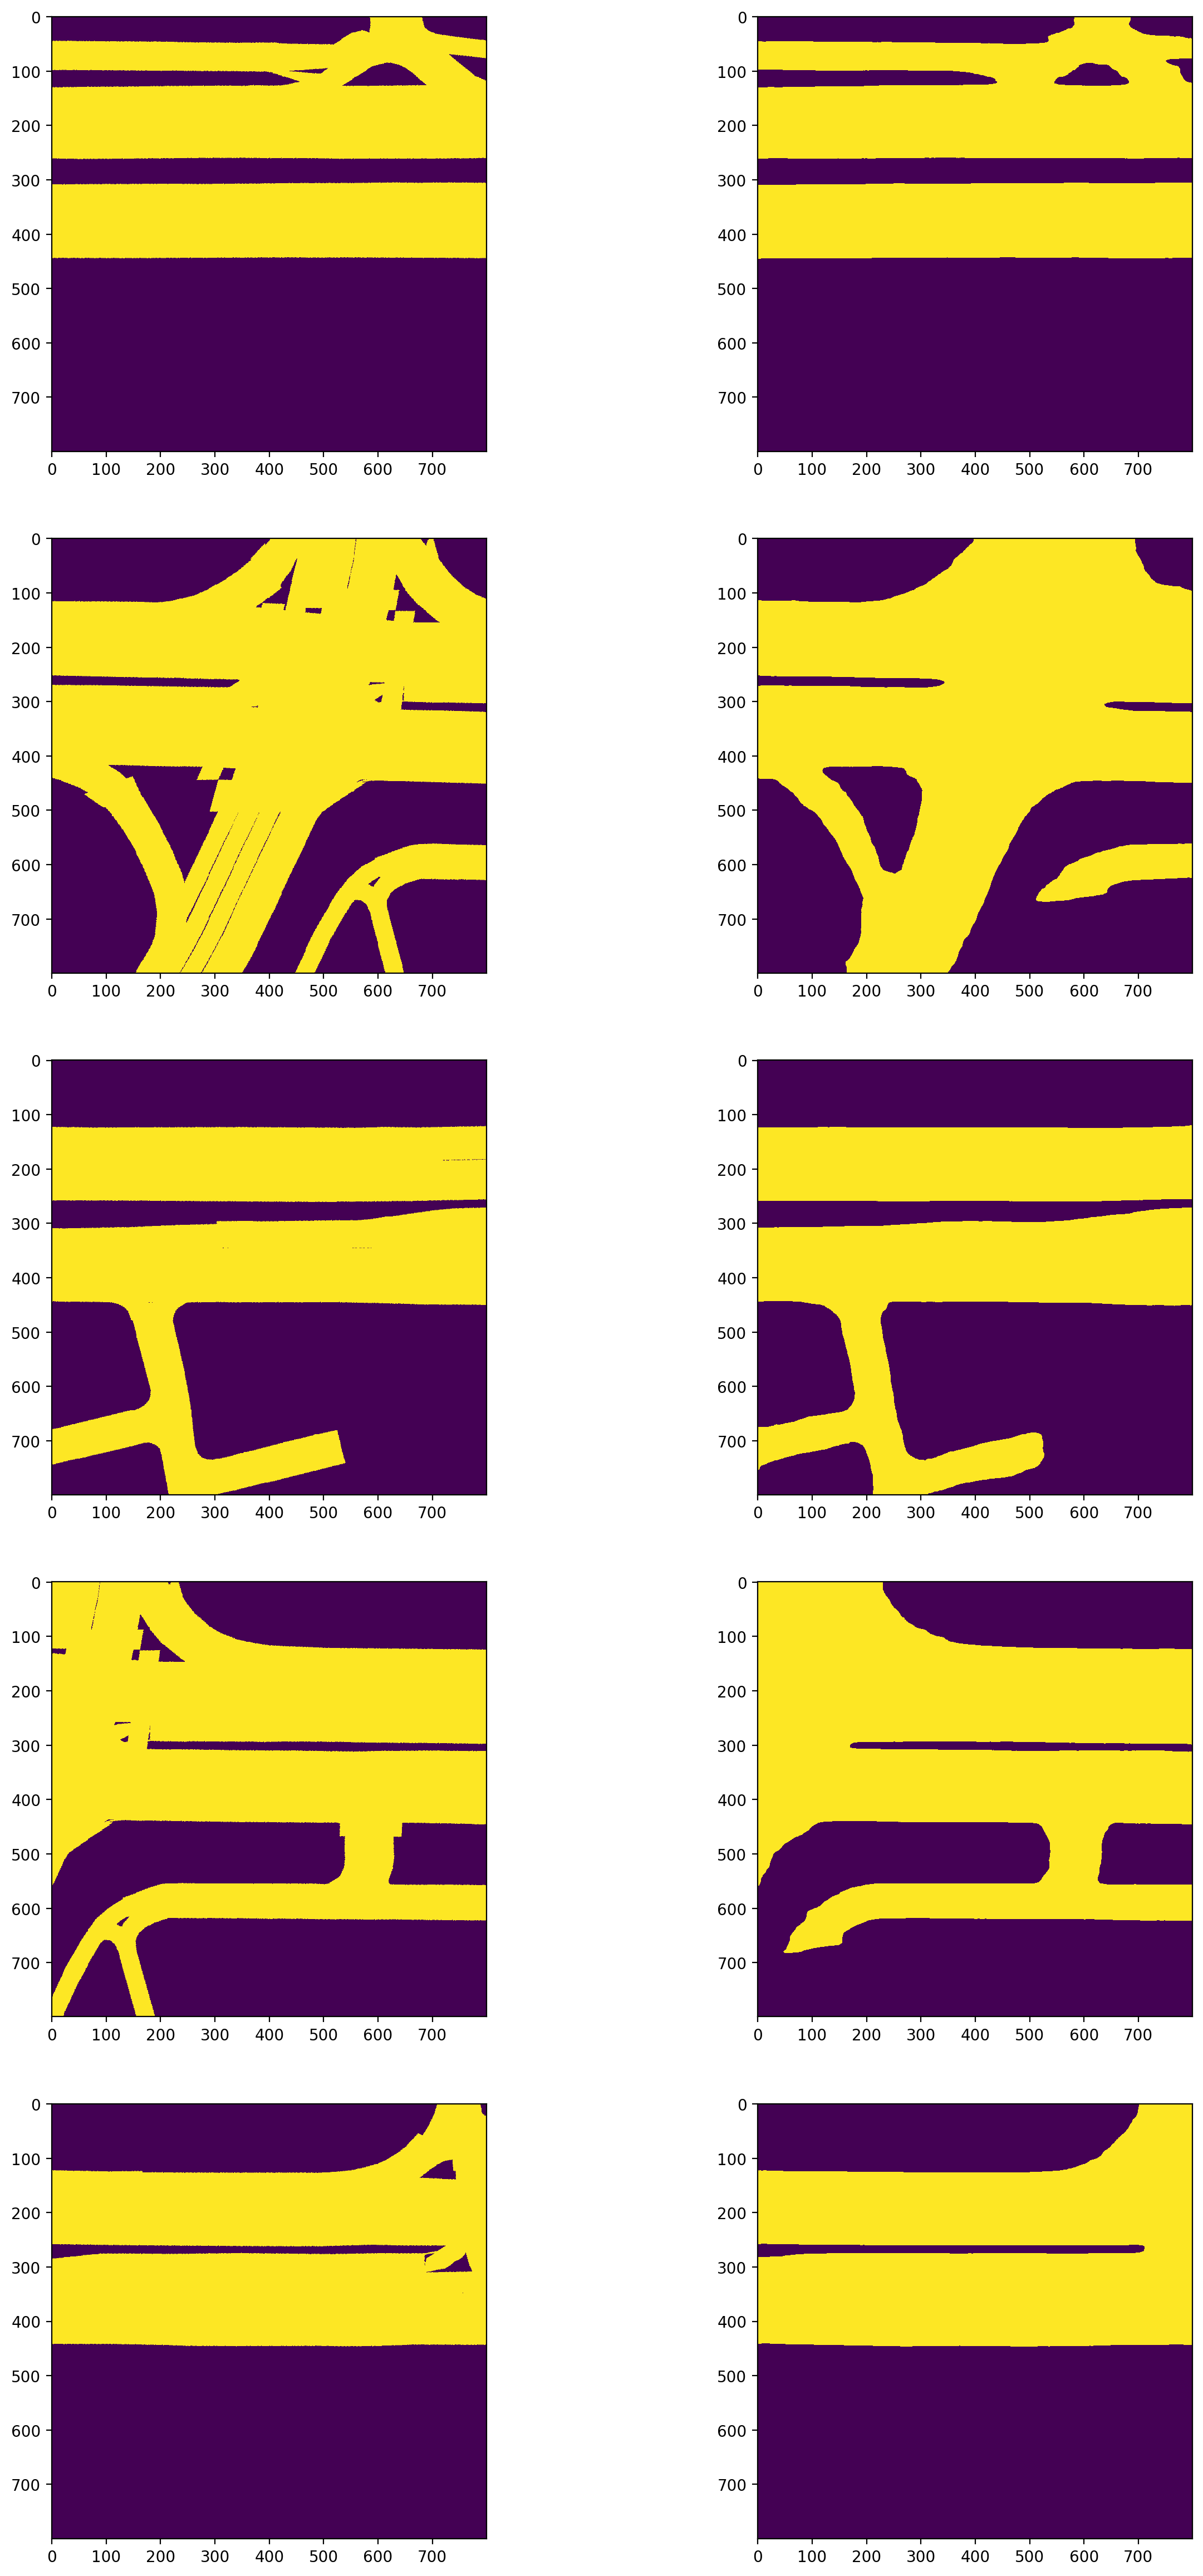

In [47]:

fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 292, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = train_set[i][0].type(torch.FloatTensor).unsqueeze(0).to(device)

    outputs = test_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(train_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())

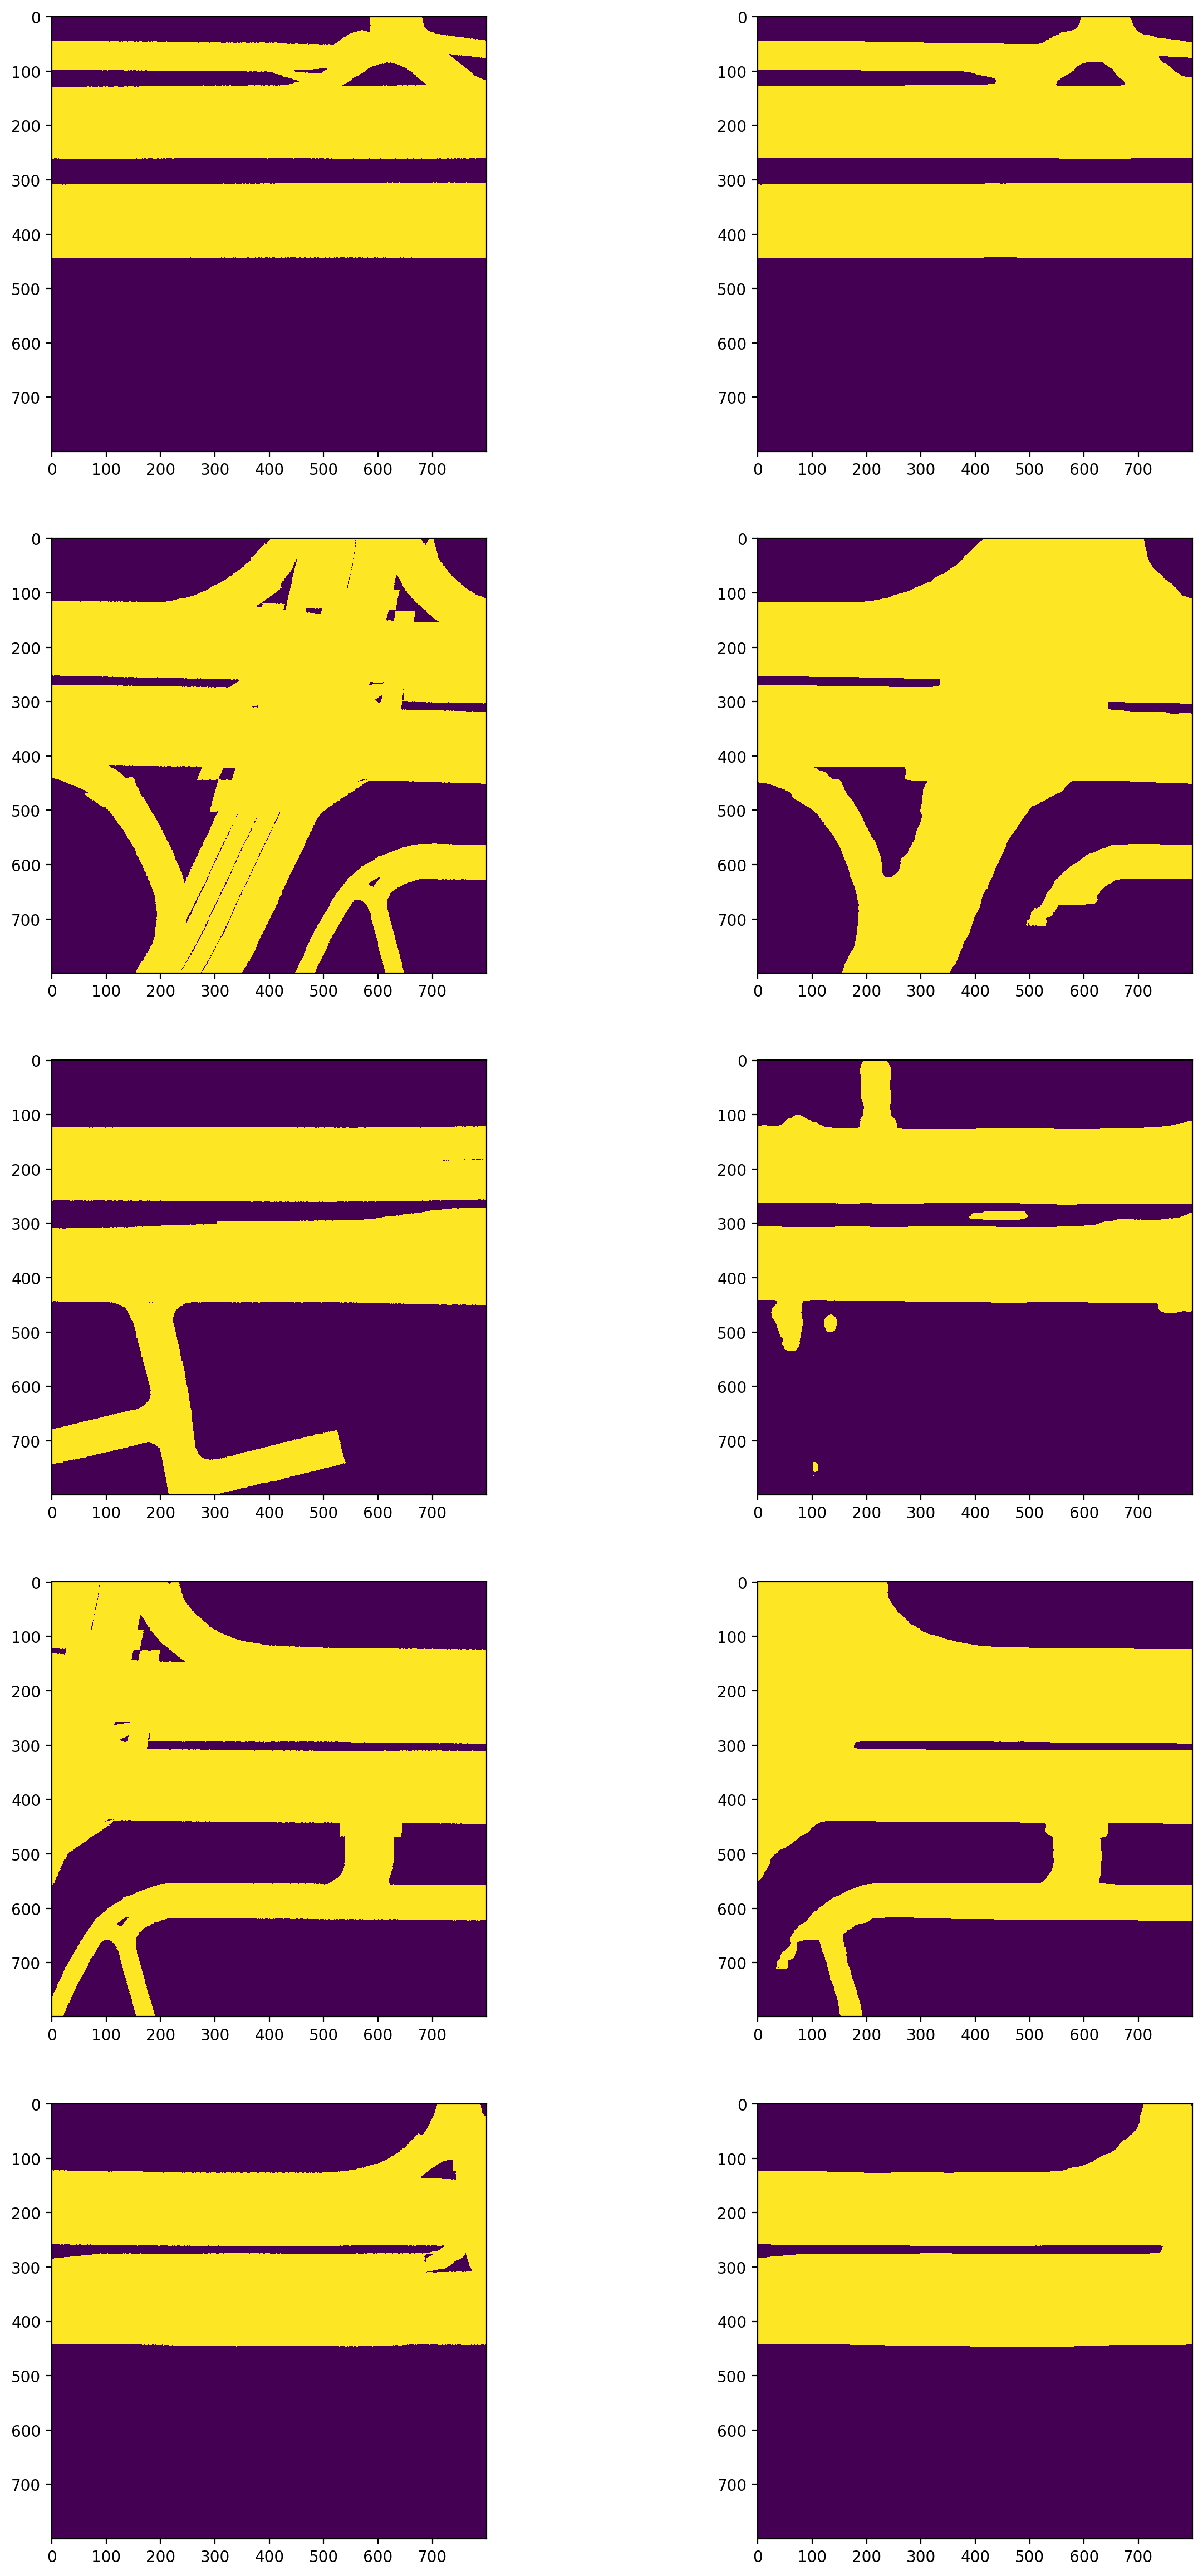

In [45]:

fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [123, 292, 419, 322, 44]
for fig_i, i in enumerate(test_idx):
    inputs = train_set[i][0].type(torch.FloatTensor).unsqueeze(0).to(device)

    outputs = my_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(train_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())

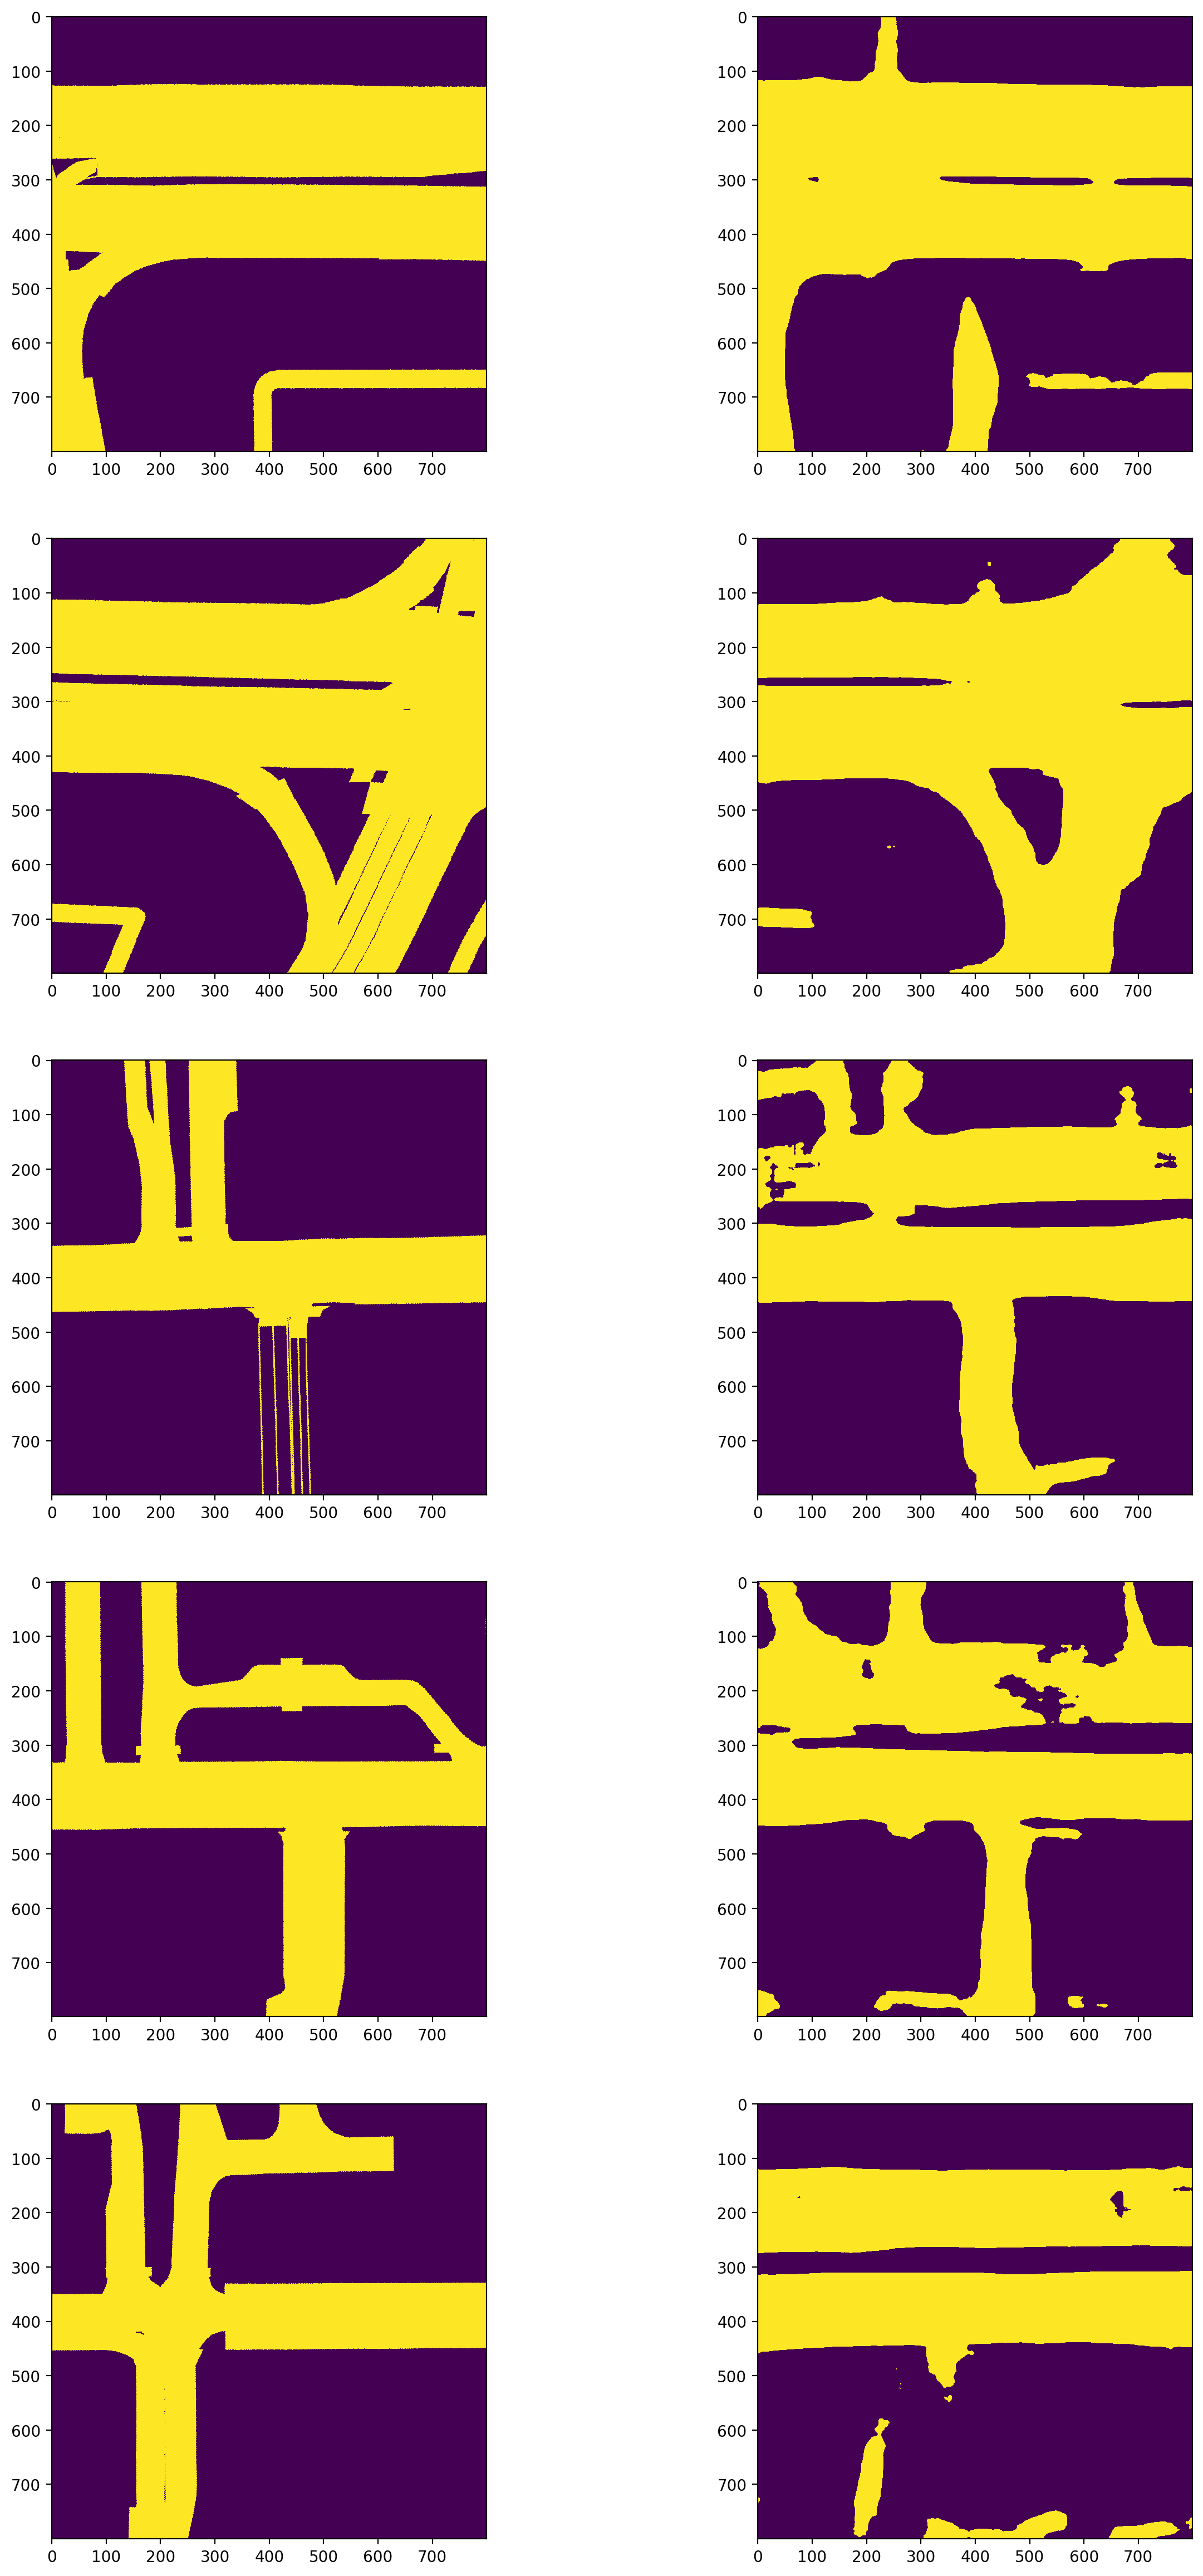

In [25]:

# test on best model performance on validation dataset
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [56,184,391,444, 500]
for fig_i, i in enumerate(test_idx):
    inputs = val_set[i][0].unsqueeze(0).to(device)

    outputs = test_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())

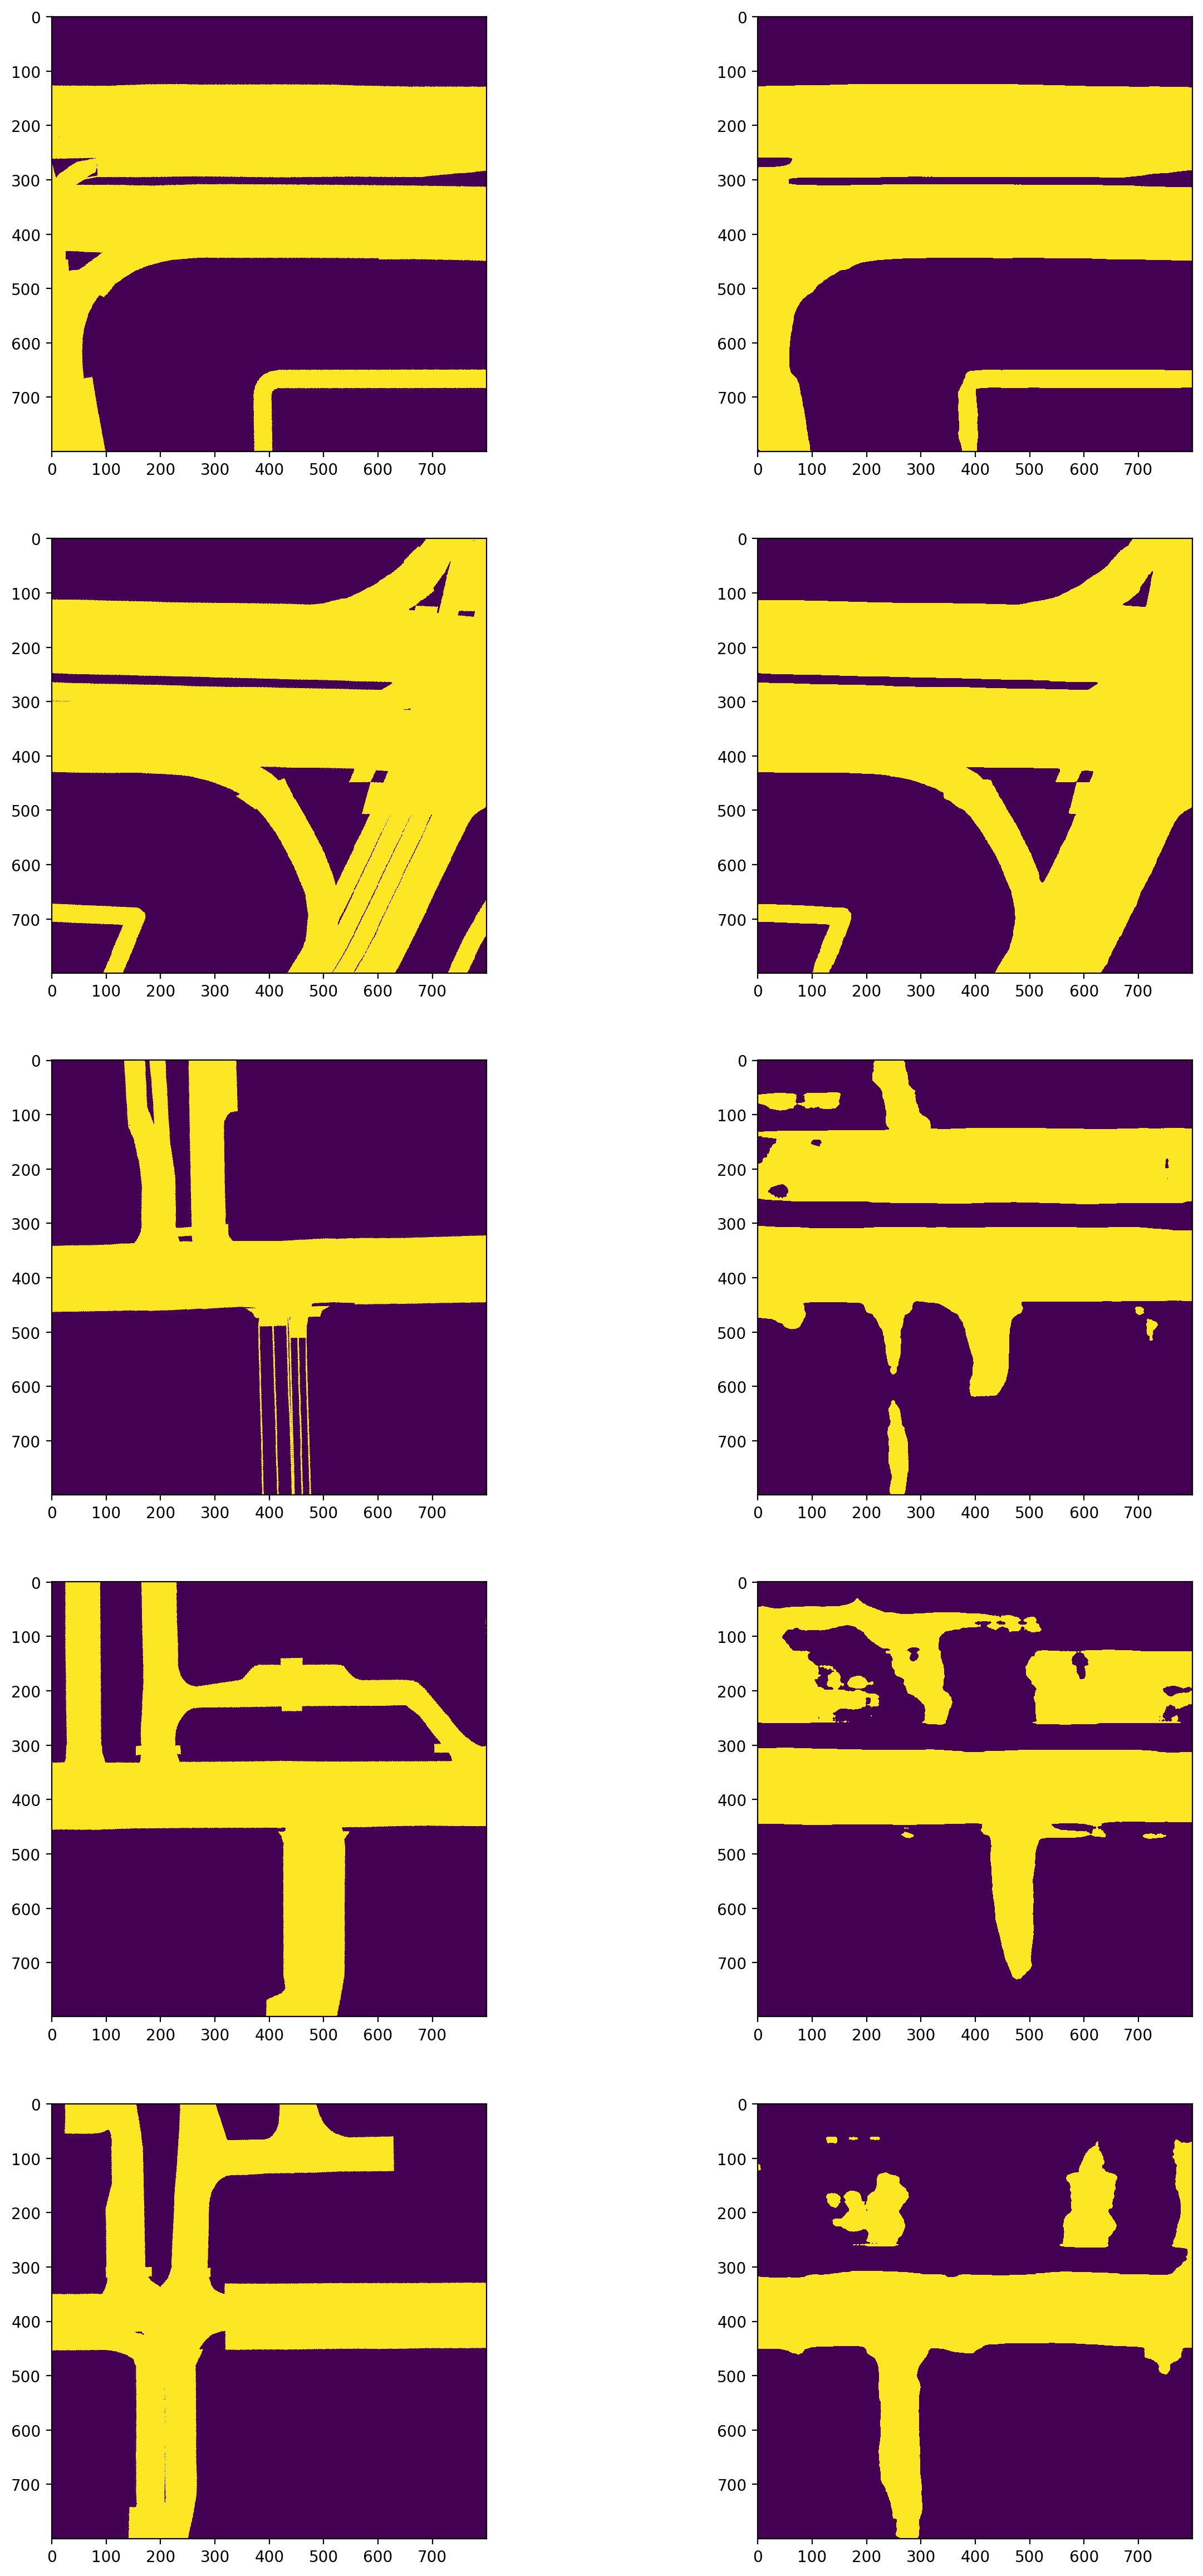

In [48]:

# test on best model performance on validation dataset
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [56,184,391,444, 500]
for fig_i, i in enumerate(test_idx):
    inputs = val_set[i][0].unsqueeze(0).to(device)

    outputs = my_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())

In [10]:
def train_eval_model(model, dataloaders,criterion, optimizer, 
                num_epochs,checkpoint, to_save, print_every=10, eval_every = 1, to_eval = False):
    
    start_time = time.time()
    
    if checkpoint:
        pt = torch.load(checkpoint)
        model.load_state_dict(pt['best_model'])
        optimizer.load_state_dict(pt['optimizer'])
        best_loss = pt['best_loss']
        print('loading weights')
    else: 
        best_loss = 1e10

    dice_dict={'train':[], 'val':[]}
    loss_dict = {'train':[], 'val':[]}
    ts_dict = []

    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            curr_dice = 0.0
            if phase == 'train':
                model.train()

            else:
                curr_ts = 0.0
                model.eval()
                
            for i, (sample, target, roadmap, extra) in enumerate(dataloaders[phase]):
                
                #target = torch.rot90(roadmap[0].int(), 1, [0,1]).type(torch.LongTensor).to(device)
                target = torch.stack(roadmap).type(torch.LongTensor).to(device)
                inputs = torch.stack(sample).type(torch.FloatTensor).to(device)
 
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output = model(inputs)
                    loss = criterion(target.cpu(), output.cpu().squeeze(1))
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                with torch.no_grad():
                    dice_score = compute_dice(target.cpu(), output.cpu().squeeze(1))

                curr_loss += loss.item()
                curr_dice += dice_score
                if phase == 'val':
                    curr_ts += compute_ts_road_map(target.cpu(), output.cpu().squeeze(1))
                
            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s dice loss is %f'%(phase, curr_loss))
            print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f'%(phase, time.time() - epoch_start))
            
            if phase == 'val':
                ts_dict.append(curr_ts/len(dataloaders[phase]))
                print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    best_model_wts = copy.deepcopy(model.state_dict())
                    checkpoint = {'best_model': best_model_wts, 
                                  'optimizer': optimizer.state_dict(), 
                                  'best_loss': curr_loss/len(dataloaders[phase])}
                    torch.save(checkpoint, to_save)
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [123, 292, 419, 322, 44]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][0].unsqueeze(0).to(device)

                outputs = model(inputs).cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    if to_eval:
        print_phase = ['train', 'val']
    else:
        print_phase = ['train']
    for phase in print_phase:
        fig = plt.figure()
        plt.plot(loss_dict[phase])
        plt.title('%s Loss per epoch'%(phase))
        plt.show()

        fig = plt.figure()
        plt.plot(dice_dict[phase])
        plt.title('%s Dice per epoch'%(phase))
        plt.show()
    
    
    return model, loss_dict, dice_dict, ts_dict, best_model_wts

In [9]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torchvision import transforms, models

import copy

class _DecoderBlock(nn.Module):
    """
    Taken from https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/models/seg_net.py
    """
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)
    
class _SameDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, out_activation = 'relu'):
        super(_SameDecoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=3),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)

# pyramid style decoder:
class PPMBilinear(nn.Module):
    def __init__(self, num_class=1, fc_dim=256,
                 pool_scales=(1, 2, 3, 6), out_size=800):
        super(PPMBilinear, self).__init__()
        self.out_size = out_size
        self.ppm = [nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                    nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                    nn.ReLU(inplace=True))]
        for scale in pool_scales[1:]:
            self.ppm.append(nn.Sequential(nn.AdaptiveAvgPool2d(scale), 
                            nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                            nn.BatchNorm2d(256), 
                            nn.ReLU(inplace=True)))
        self.ppm = nn.ModuleList(self.ppm)

        self.pool_conv = nn.Sequential(
            nn.Conv2d(fc_dim+len(pool_scales)*256, 256,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            # nn.Conv2d(512, num_class, kernel_size=1)
        )
        self.conv_last = nn.Sequential(*[_SameDecoder(256, 256), 
                                         _DecoderBlock(256, 128, 2),
                                         _DecoderBlock(128, 64, 2), 
                                         _DecoderBlock(64, 32, 2), 
                                         _DecoderBlock(32, 1, 2, 'Sigmoid')])
        
        # self.sigmoid = nn.Sigmoid()
    def forward(self, conv_out):
        conv5 = conv_out[-1]

        input_size = conv5.size()
             
        ppm_out = [conv5]
        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(
                pool_scale(conv5),
                (input_size[2], input_size[3]),
                mode='bilinear', align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)
        # print(ppm_out.shape)
        x = self.pool_conv(ppm_out)
        #feat = x
        x  =self.conv_last(x)
        # print(x.shape)
        x = nn.functional.interpolate(x, (self.out_size,self.out_size), mode='bilinear', align_corners = False)
        
        return x

class TransformModule(nn.Module):
    '''
    Modified from https://github.com/pbw-Berwin/View-Parsing-Network/blob/dc0c4250302b84a8594f291a494b5e8969291e1b/segmentTool/models.py
    '''
    def __init__(self, dim1, dim2, num_view = 6):
        super(TransformModule, self).__init__()
        self.num_view = num_view
        self.dim1 = dim1
        self.dim2 = dim2
        self.mat_list = nn.ModuleList()
        
        for i in range(self.num_view):
            # weights are not shared
            fc_transform = nn.Sequential(
                        nn.Linear(dim1* dim2, dim1*dim2*4), 
                        nn.ReLU(), 
                        nn.Linear(dim1 * dim2*4, dim1*dim2),
                        nn.ReLU()
            )
            self.mat_list += [fc_transform]
    
    def forward(self, x):
        # shape B V C H W
        # flatten along the channel
        x = x.view(list(x.size()[:3]) + [self.dim1 * self.dim2,])
        # Transform the first image
        view_comb = self.mat_list[0](x[:, 0])
        for i in range(1, x.size(1)):
            # results are added(fusion func)
            view_comb += self.mat_list[i](x[:, i])
        view_comb = view_comb.view(list(view_comb.size()[:2]) + [self.dim1, self.dim2]) 
        return view_comb
        

class vpn_model(nn.Module):
    def __init__(self, dim1, dim2, encoder, decoder):
        super(vpn_model, self).__init__()
        self.num_views = 6
        self.encoder = encoder
        
        self.transform = TransformModule(dim1=dim1, dim2=dim2)
        
        self.decoder = decoder
        
        
    def forward(self, x, return_feat = False):
        # flatten the output along channel: C x (HW)
        # weights are not shared, i.e. each first view input has
        # own VRM to get its top down view feature map 
        # i here in range 6(MN, N=6,M=1(MODALITY))
        # j here in range num_channels
        # 
        B,V,C,H,W = x.shape
        x = x.view(B*V, C, H, W)
        x = self.encoder(x)
        # return to B V 
        x = x.view([B,V] + list(x.size()[1:]))
        x =  self.transform(x) # B x c x h x w
        
        x = self.decoder([x])

        return x

Epoch 1/5
----------
current epoch train dice loss is 944.249269
current epoch train dice coef is 913.875610
training 1 epoch takes 439.216230
current epoch val dice loss is 191.951551
current epoch val dice coef is 156.024155
valing 1 epoch takes 477.032326
current ts is 0.456149
saving best model
printing test image


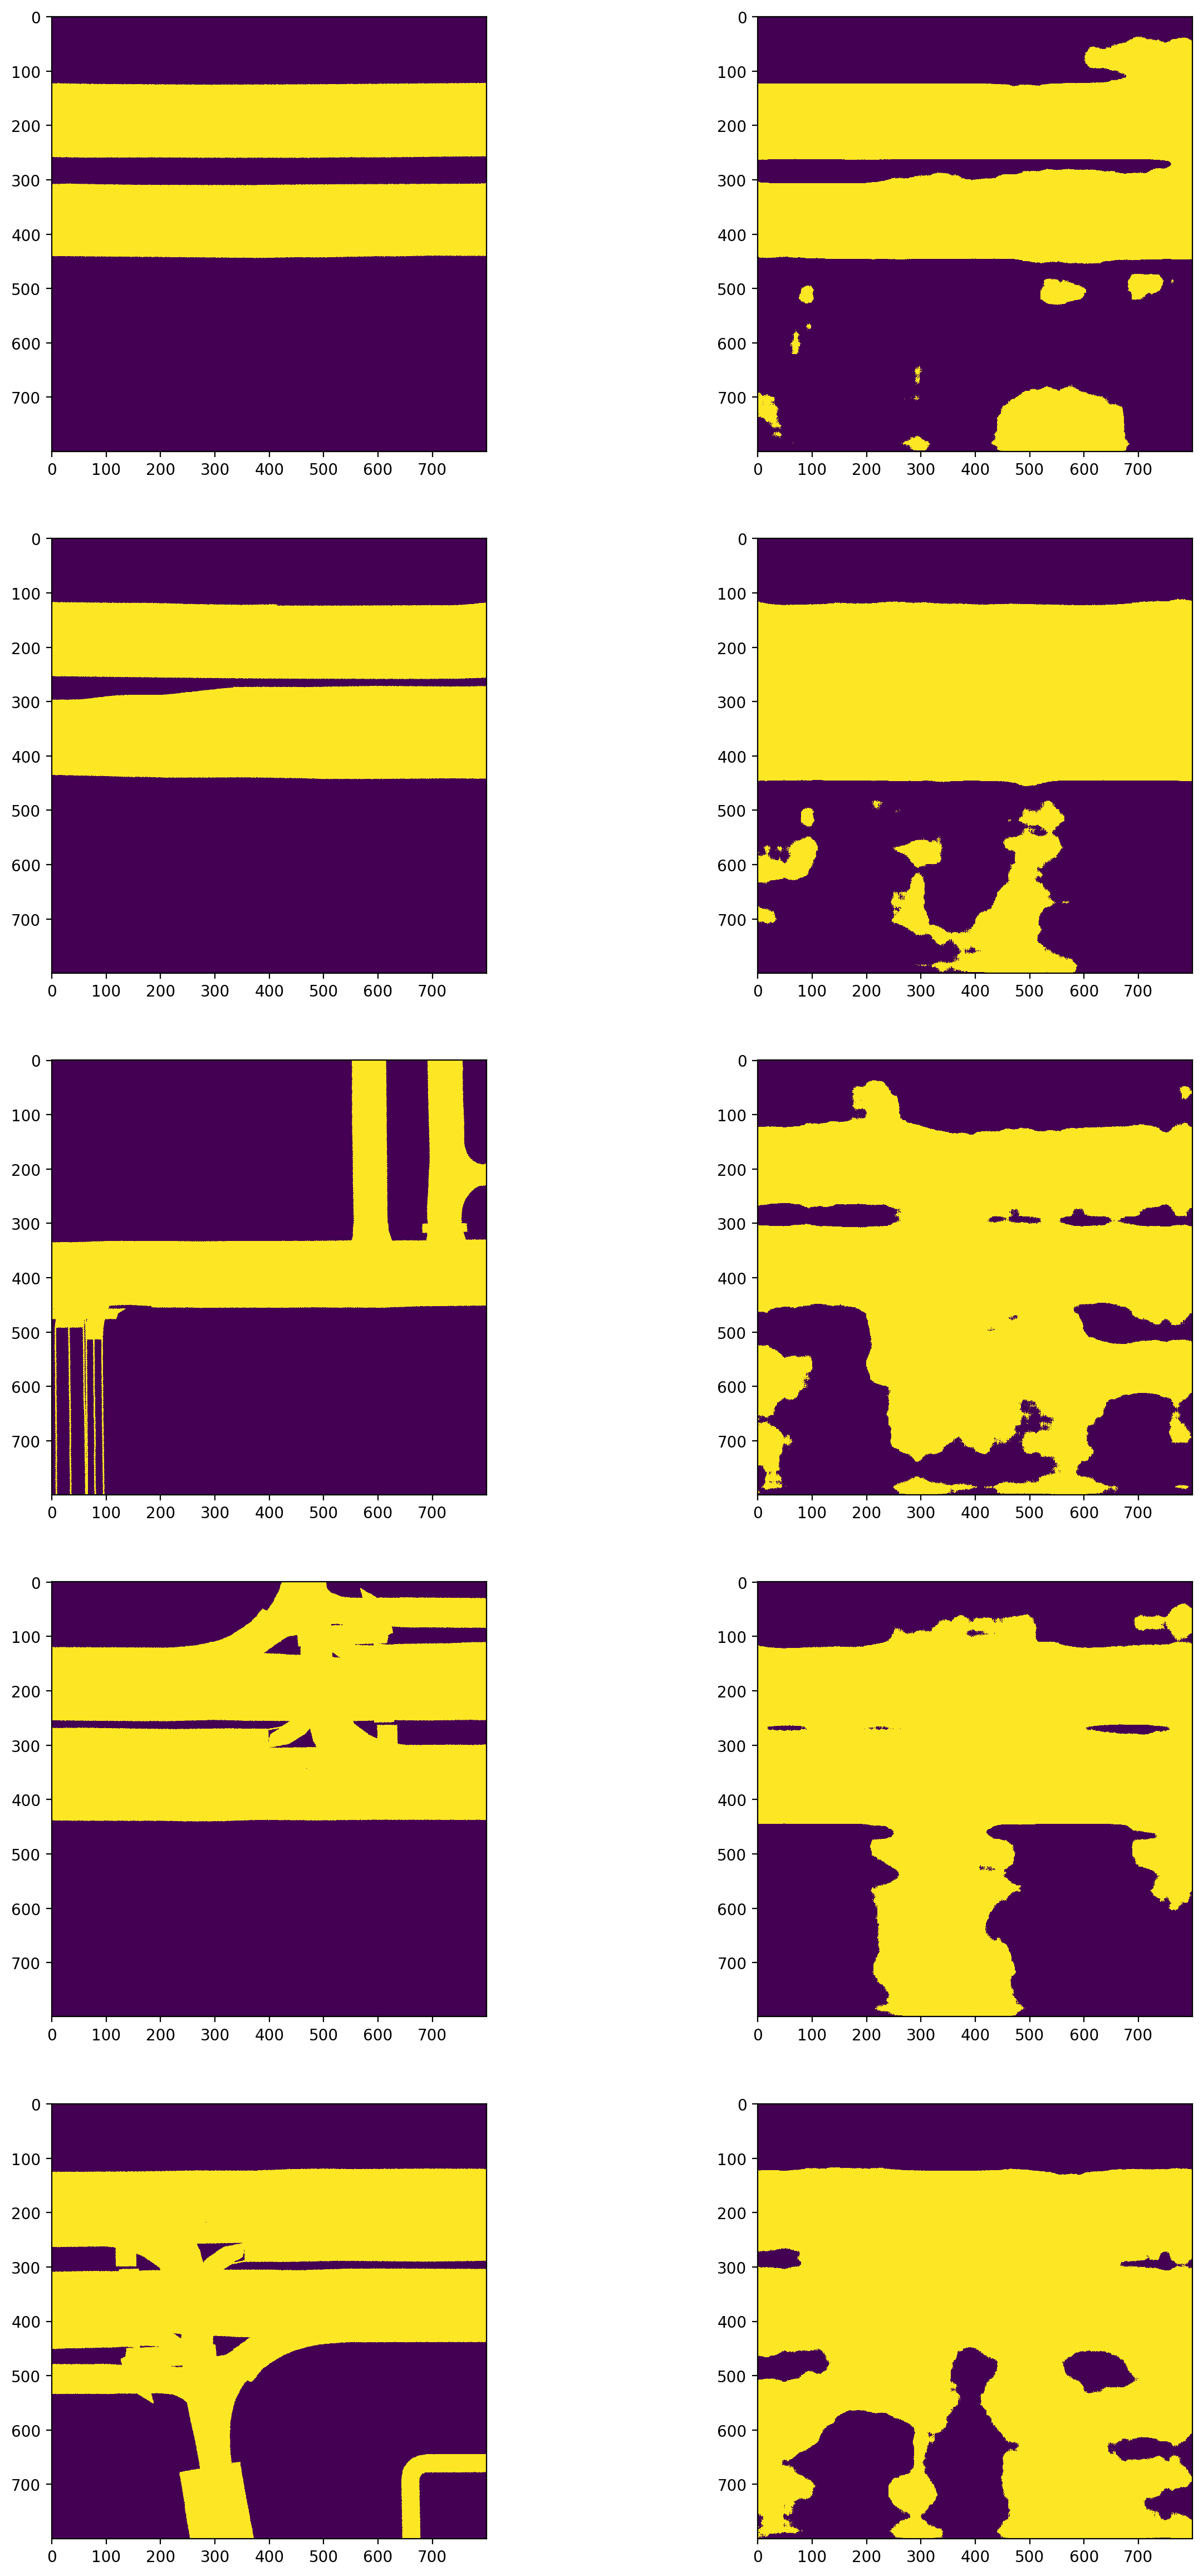

Epoch 2/5
----------
current epoch train dice loss is 768.381277
current epoch train dice coef is 1001.809387
training 1 epoch takes 429.683989
current epoch val dice loss is 160.958799
current epoch val dice coef is 171.520599
valing 1 epoch takes 462.210125
current ts is 0.526237
saving best model
Epoch 3/5
----------
current epoch train dice loss is 639.603710
current epoch train dice coef is 1066.198608
training 1 epoch takes 461.933441
current epoch val dice loss is 153.074304
current epoch val dice coef is 175.462830
valing 1 epoch takes 498.869022
current ts is 0.545661
saving best model
Epoch 4/5
----------
current epoch train dice loss is 536.037031
current epoch train dice coef is 1117.981567
training 1 epoch takes 407.391296
current epoch val dice loss is 134.002786
current epoch val dice coef is 184.998581
valing 1 epoch takes 444.744784
current ts is 0.595280
saving best model
Epoch 5/5
----------
current epoch train dice loss is 449.806638
current epoch train dice coef is

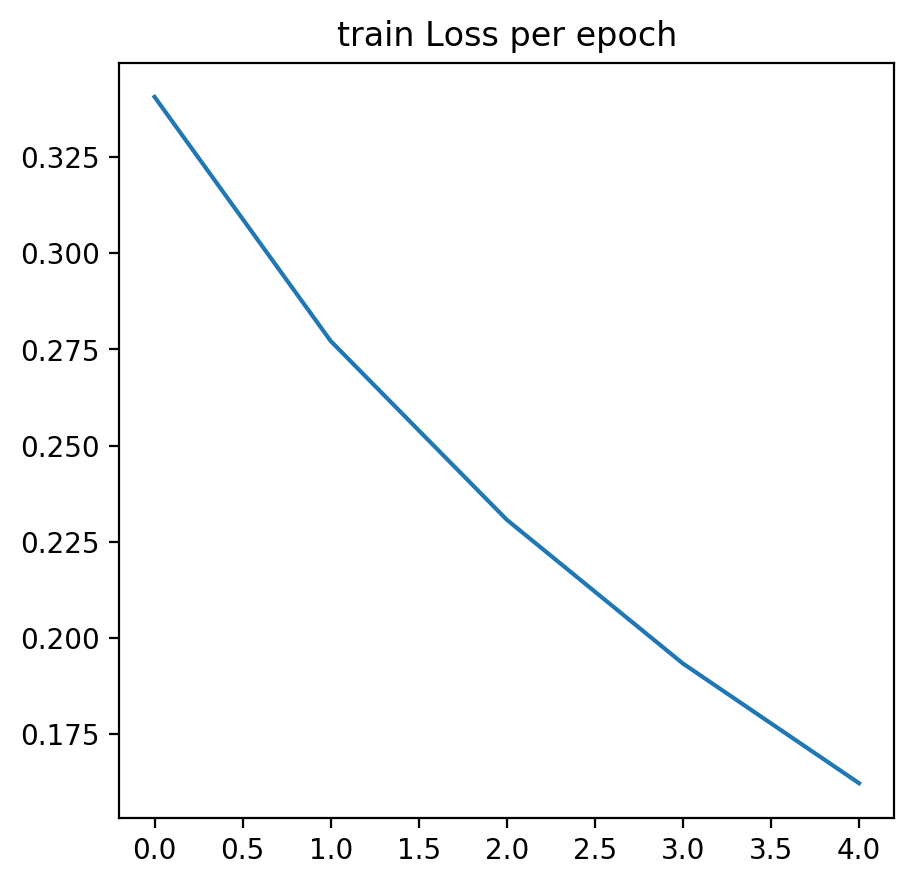

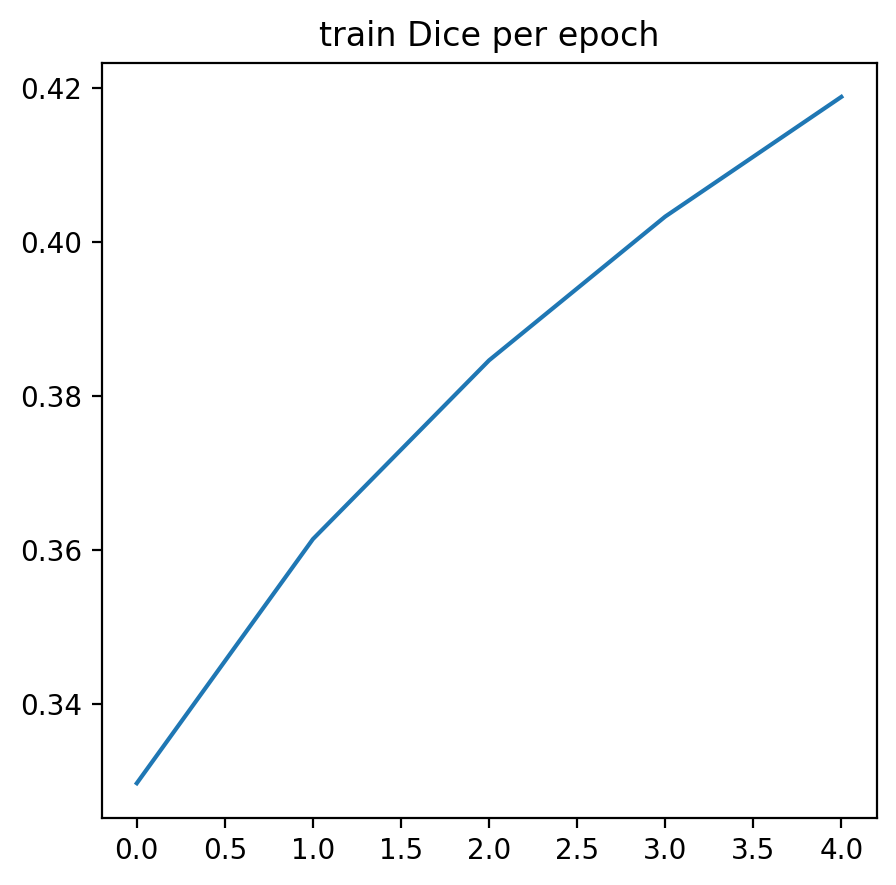

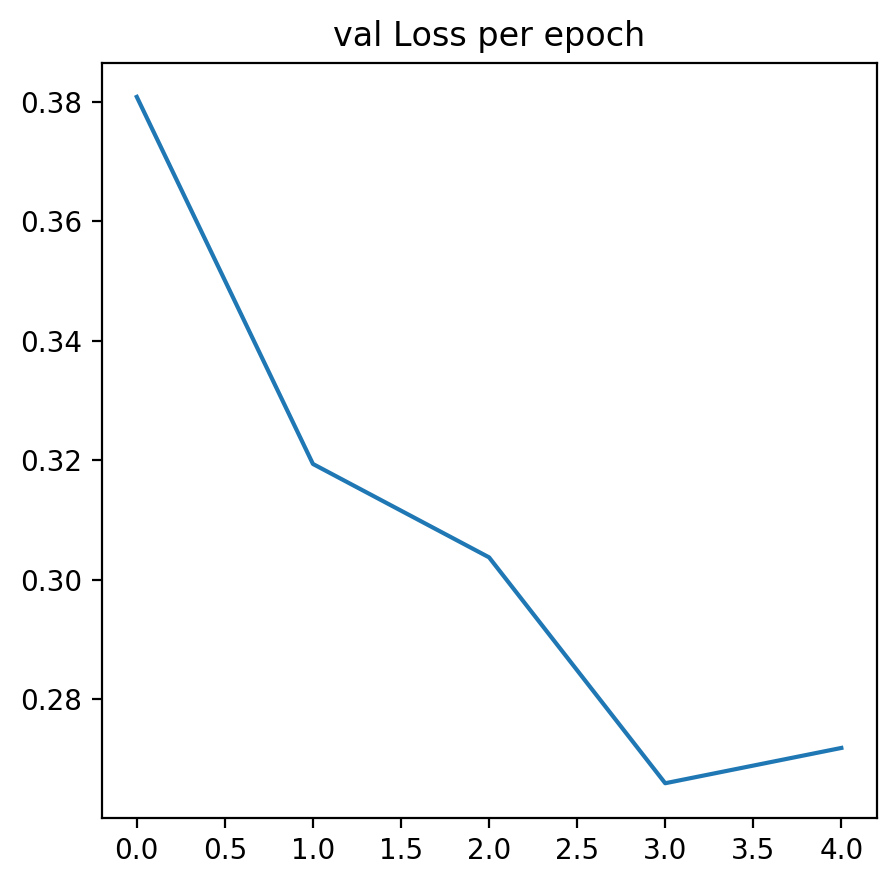

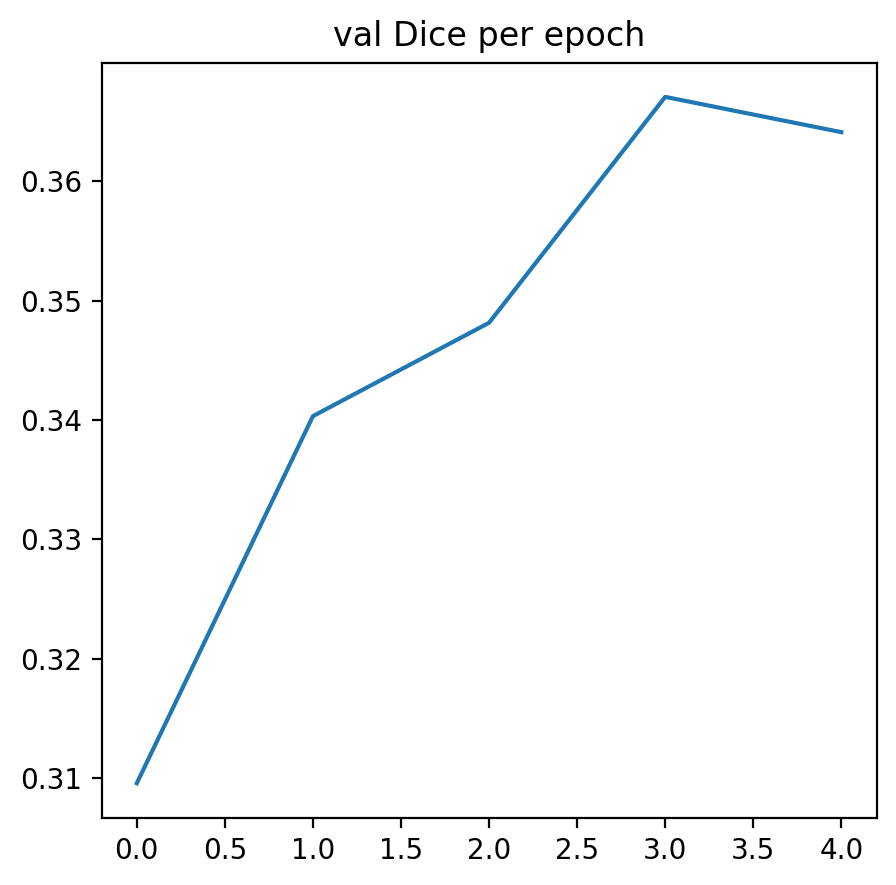

In [15]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder1 = torchvision.models.resnet50(pretrained = False)
resnet_encoder1 = list(resnet_encoder1.children())[:-3]
resnet_encoder1 = nn.Sequential(*resnet_encoder1)
for param in resnet_encoder1.parameters():
    param.requires_grad = True
resnet_encoder1 = resnet_encoder1.to(device)

DIM1 = 16
DIM2 = 20
decoder1 = PPMBilinear(fc_dim=1024).to(device)
my_model1 = vpn_model(DIM1, DIM2, resnet_encoder1, decoder1).to(device)
optimizer1 = torch.optim.Adam(my_model1.parameters(), lr = 1e-4)
dataloaders = {'train': train_loader, 'val': val_loader}
model1, loss_dict1, dice_dict1, ts_loss1, best_model_wts1 = train_eval_model(my_model1, 
                                                                 dataloaders, 
                                                                 dice_loss, 
                                                                 optimizer1, 
                                                                 num_epochs=5,
                                                                 print_every=10,
                                                                 eval_every=1,
                                                                 to_eval=True)

loading weights
Epoch 1/5
----------
current epoch train dice loss is 450.118450
current epoch train dice coef is 1160.940308
training 1 epoch takes 513.418538
current epoch val dice loss is 141.163529
current epoch val dice coef is 181.418167
valing 1 epoch takes 544.454319
current ts is 0.579048
printing test image


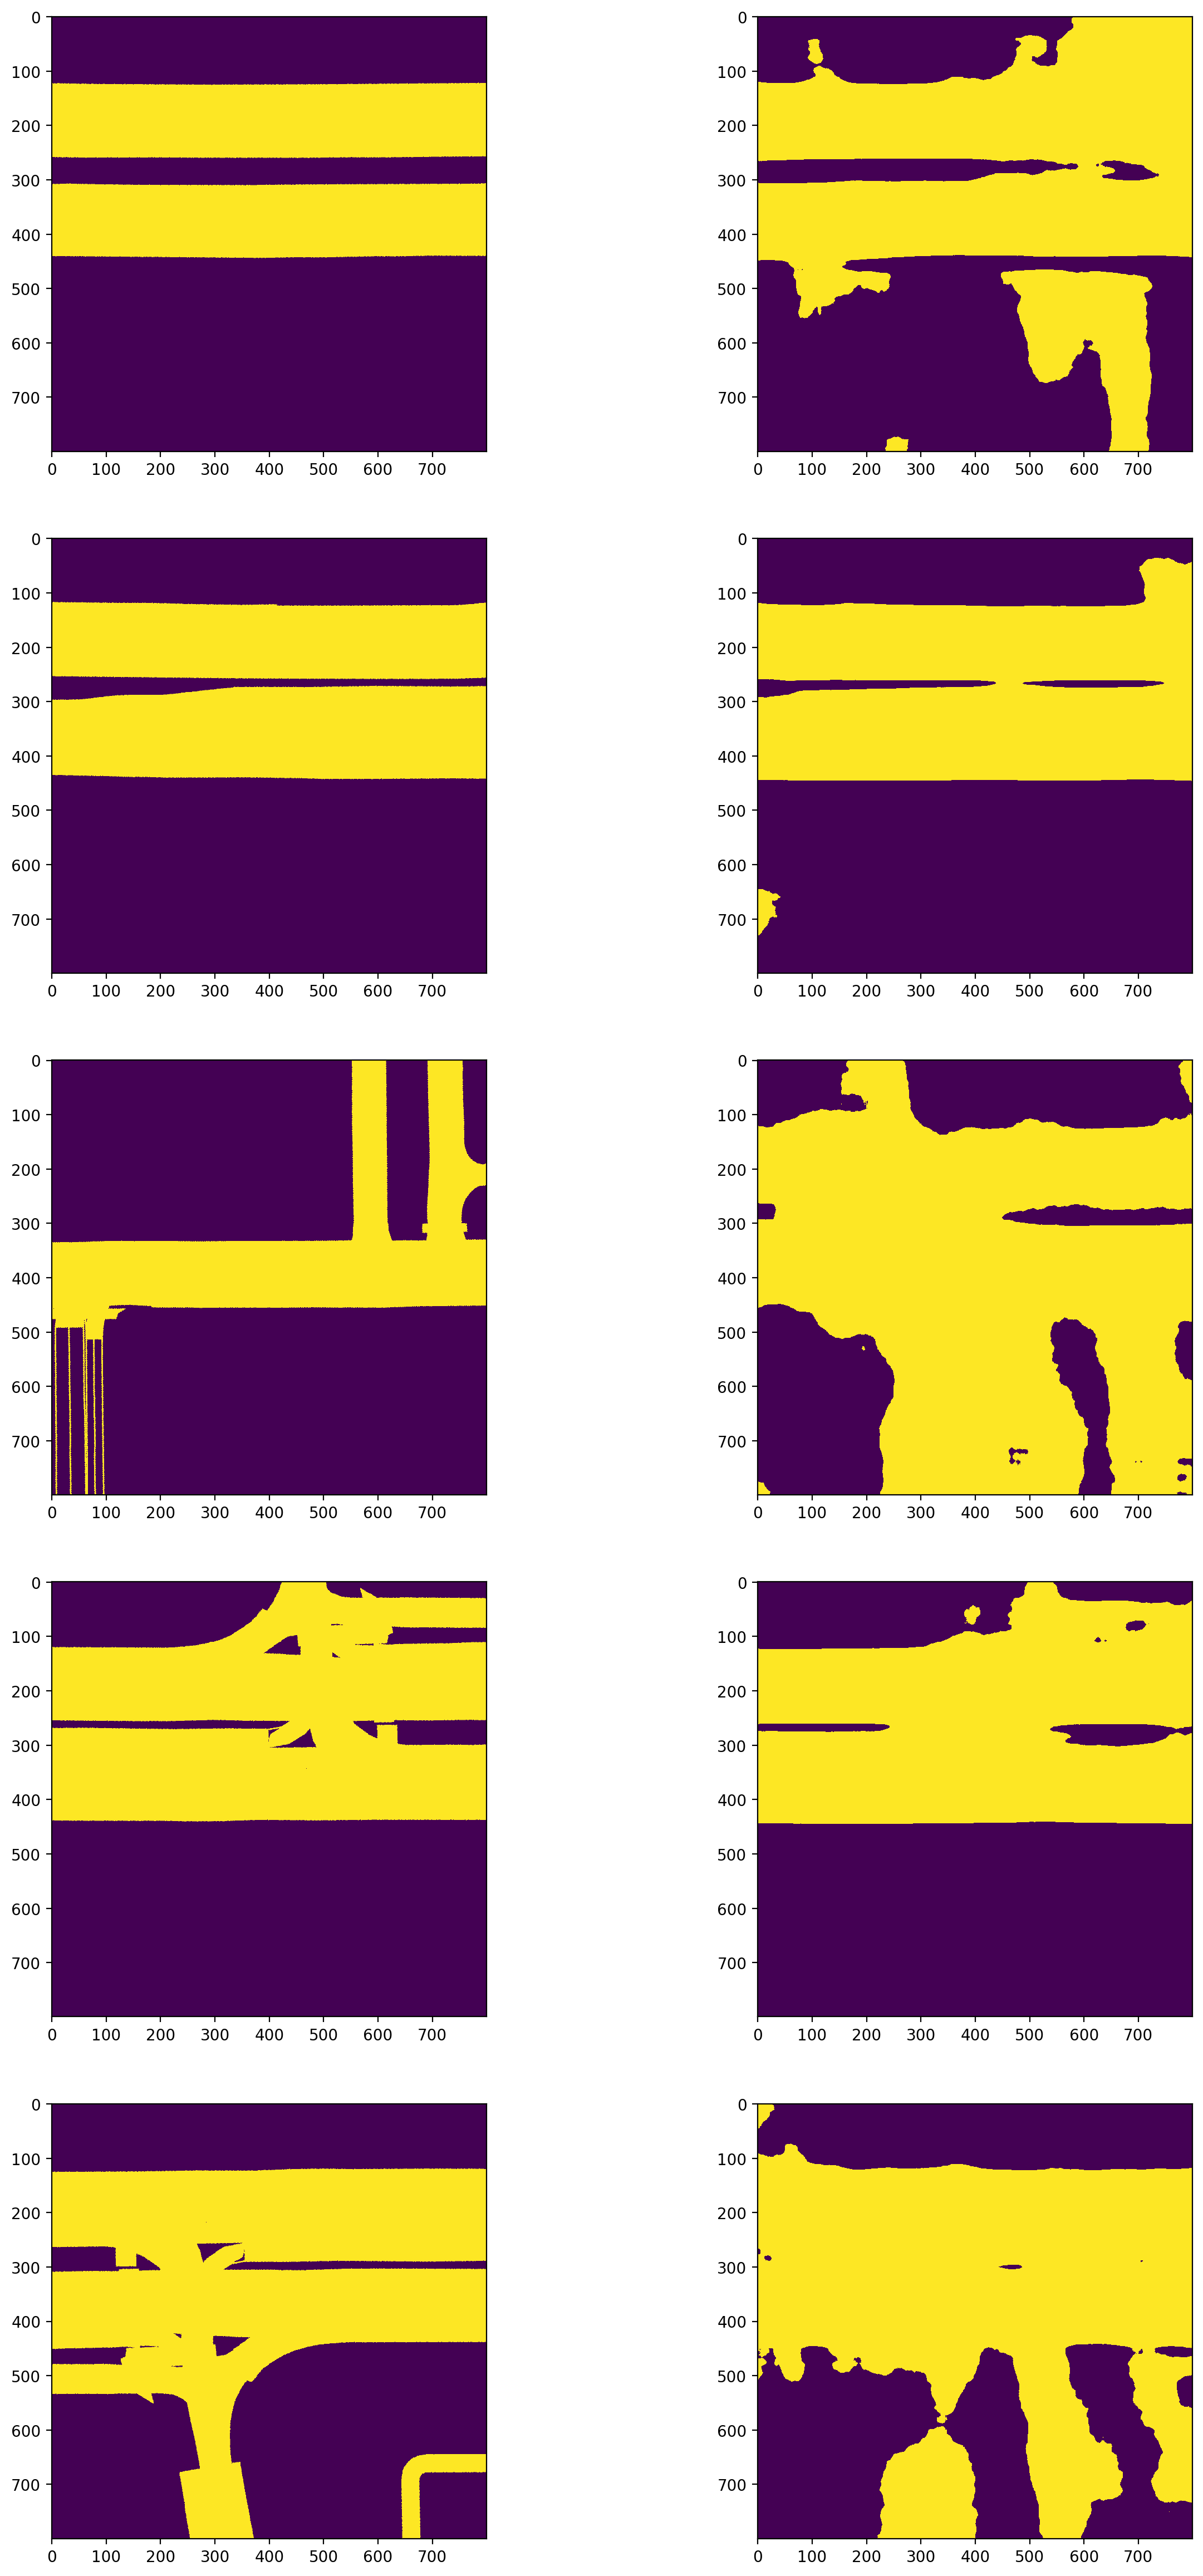

Epoch 2/5
----------
current epoch train dice loss is 378.445841
current epoch train dice coef is 1196.779053
training 1 epoch takes 459.958656
current epoch val dice loss is 120.330092
current epoch val dice coef is 191.835022
valing 1 epoch takes 492.277752
current ts is 0.633745
saving best model
Epoch 3/5
----------
current epoch train dice loss is 319.509654
current epoch train dice coef is 1226.246460
training 1 epoch takes 465.126560
current epoch val dice loss is 126.124046
current epoch val dice coef is 188.937927
valing 1 epoch takes 497.657284
current ts is 0.619816
Epoch 4/5
----------
current epoch train dice loss is 271.549688
current epoch train dice coef is 1250.224609
training 1 epoch takes 455.732703
current epoch val dice loss is 114.912485
current epoch val dice coef is 194.543732
valing 1 epoch takes 486.089709
current ts is 0.651143
saving best model
Epoch 5/5
----------
current epoch train dice loss is 232.528840
current epoch train dice coef is 1269.734863
train

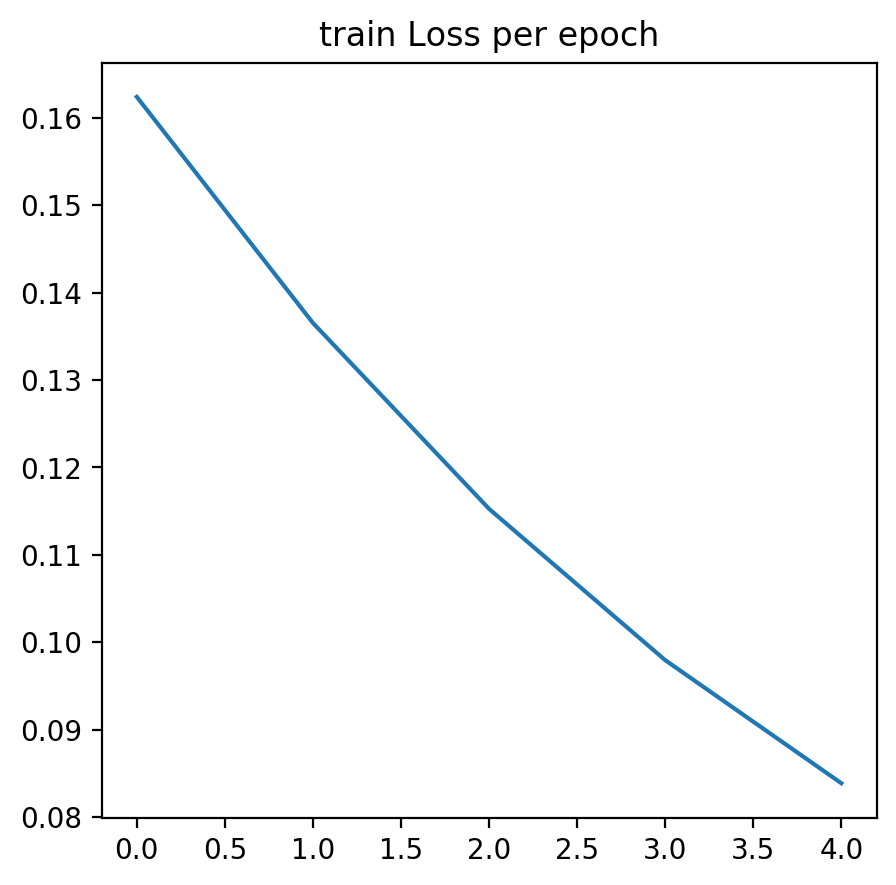

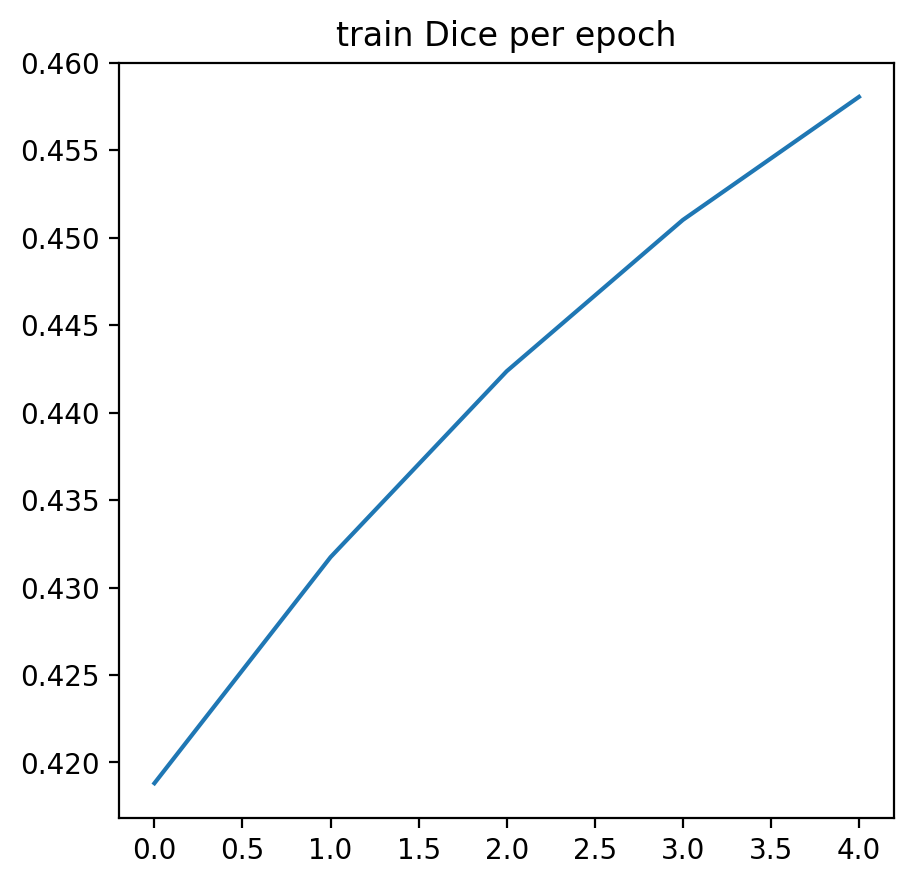

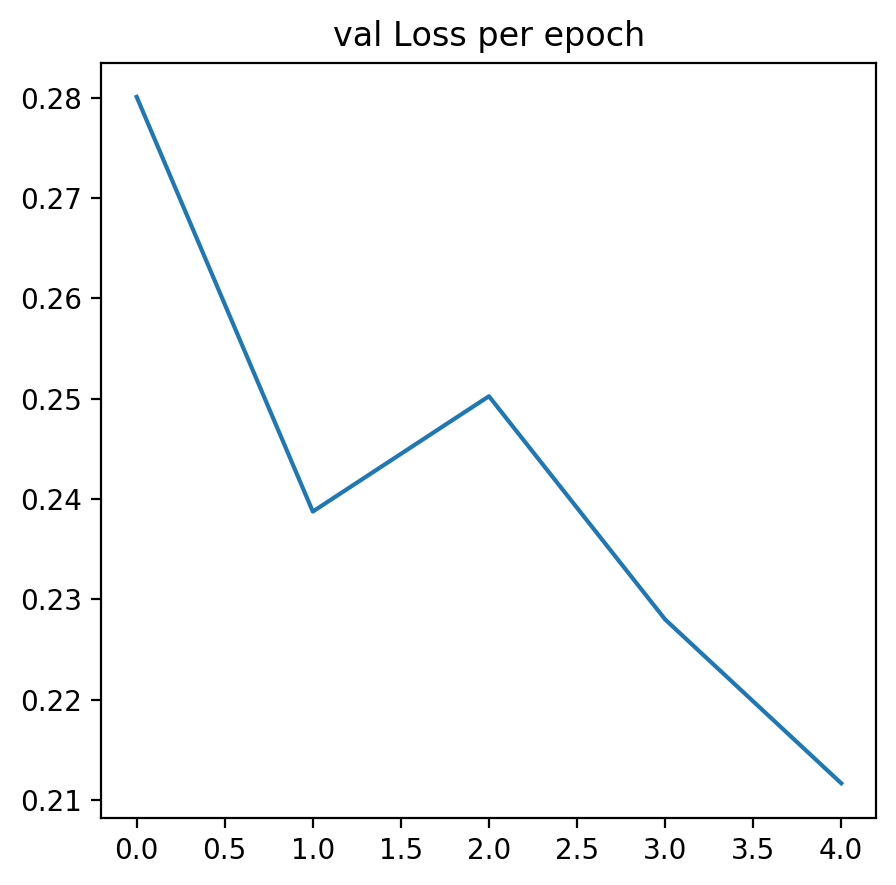

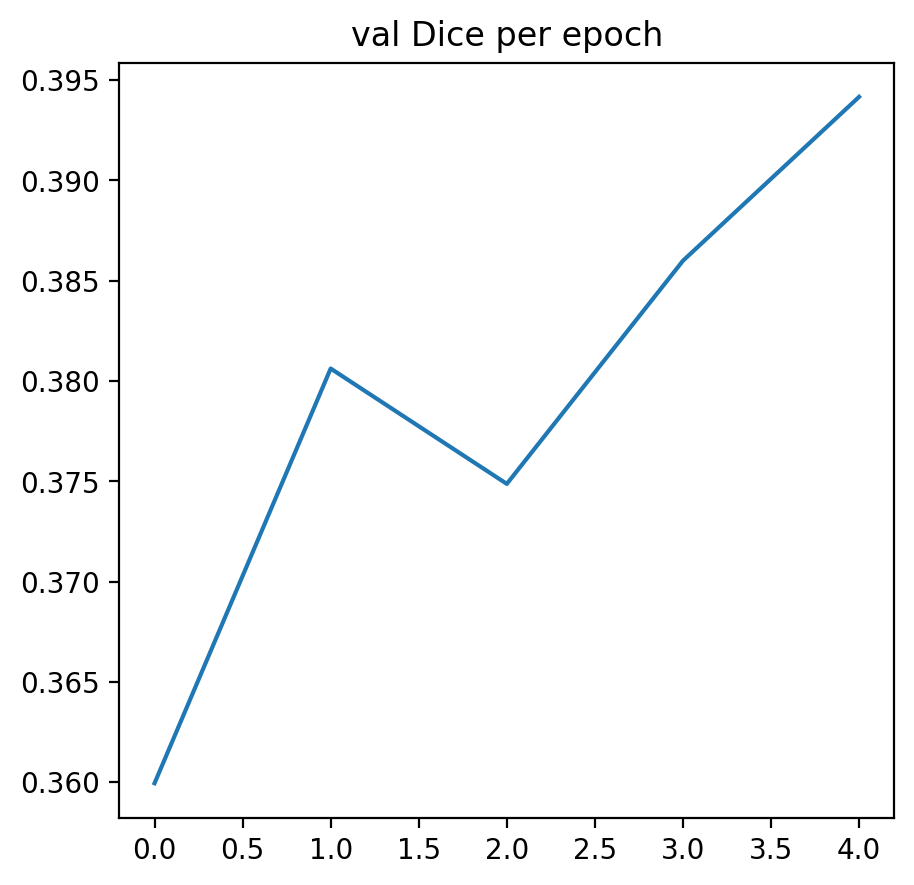

In [21]:
model1, loss_dict1, dice_dict1, ts_loss1, best_model_wts1 = train_eval_model(model1, 
                                                                 dataloaders, 
                                                                 dice_loss, 
                                                                 optimizer1, 
                                                                 num_epochs=5,
                                                                 checkpoint = '/scratch/ht1162/DLResult/supervised_train_res50.pth',
                                                                 to_save = '/scratch/ht1162/DLResult/supervised_train_res50.pth',           
                                                                 print_every=10,
                                                                 eval_every=1,
                                                                 to_eval=True)

loading weights
Epoch 1/10
----------
current epoch train dice loss is 200.105648
current epoch train dice coef is 1285.947876
training 1 epoch takes 461.462202
current epoch val dice loss is 97.858558
current epoch val dice coef is 203.070740
valing 1 epoch takes 495.261803
current ts is 0.699719
saving best model
printing test image


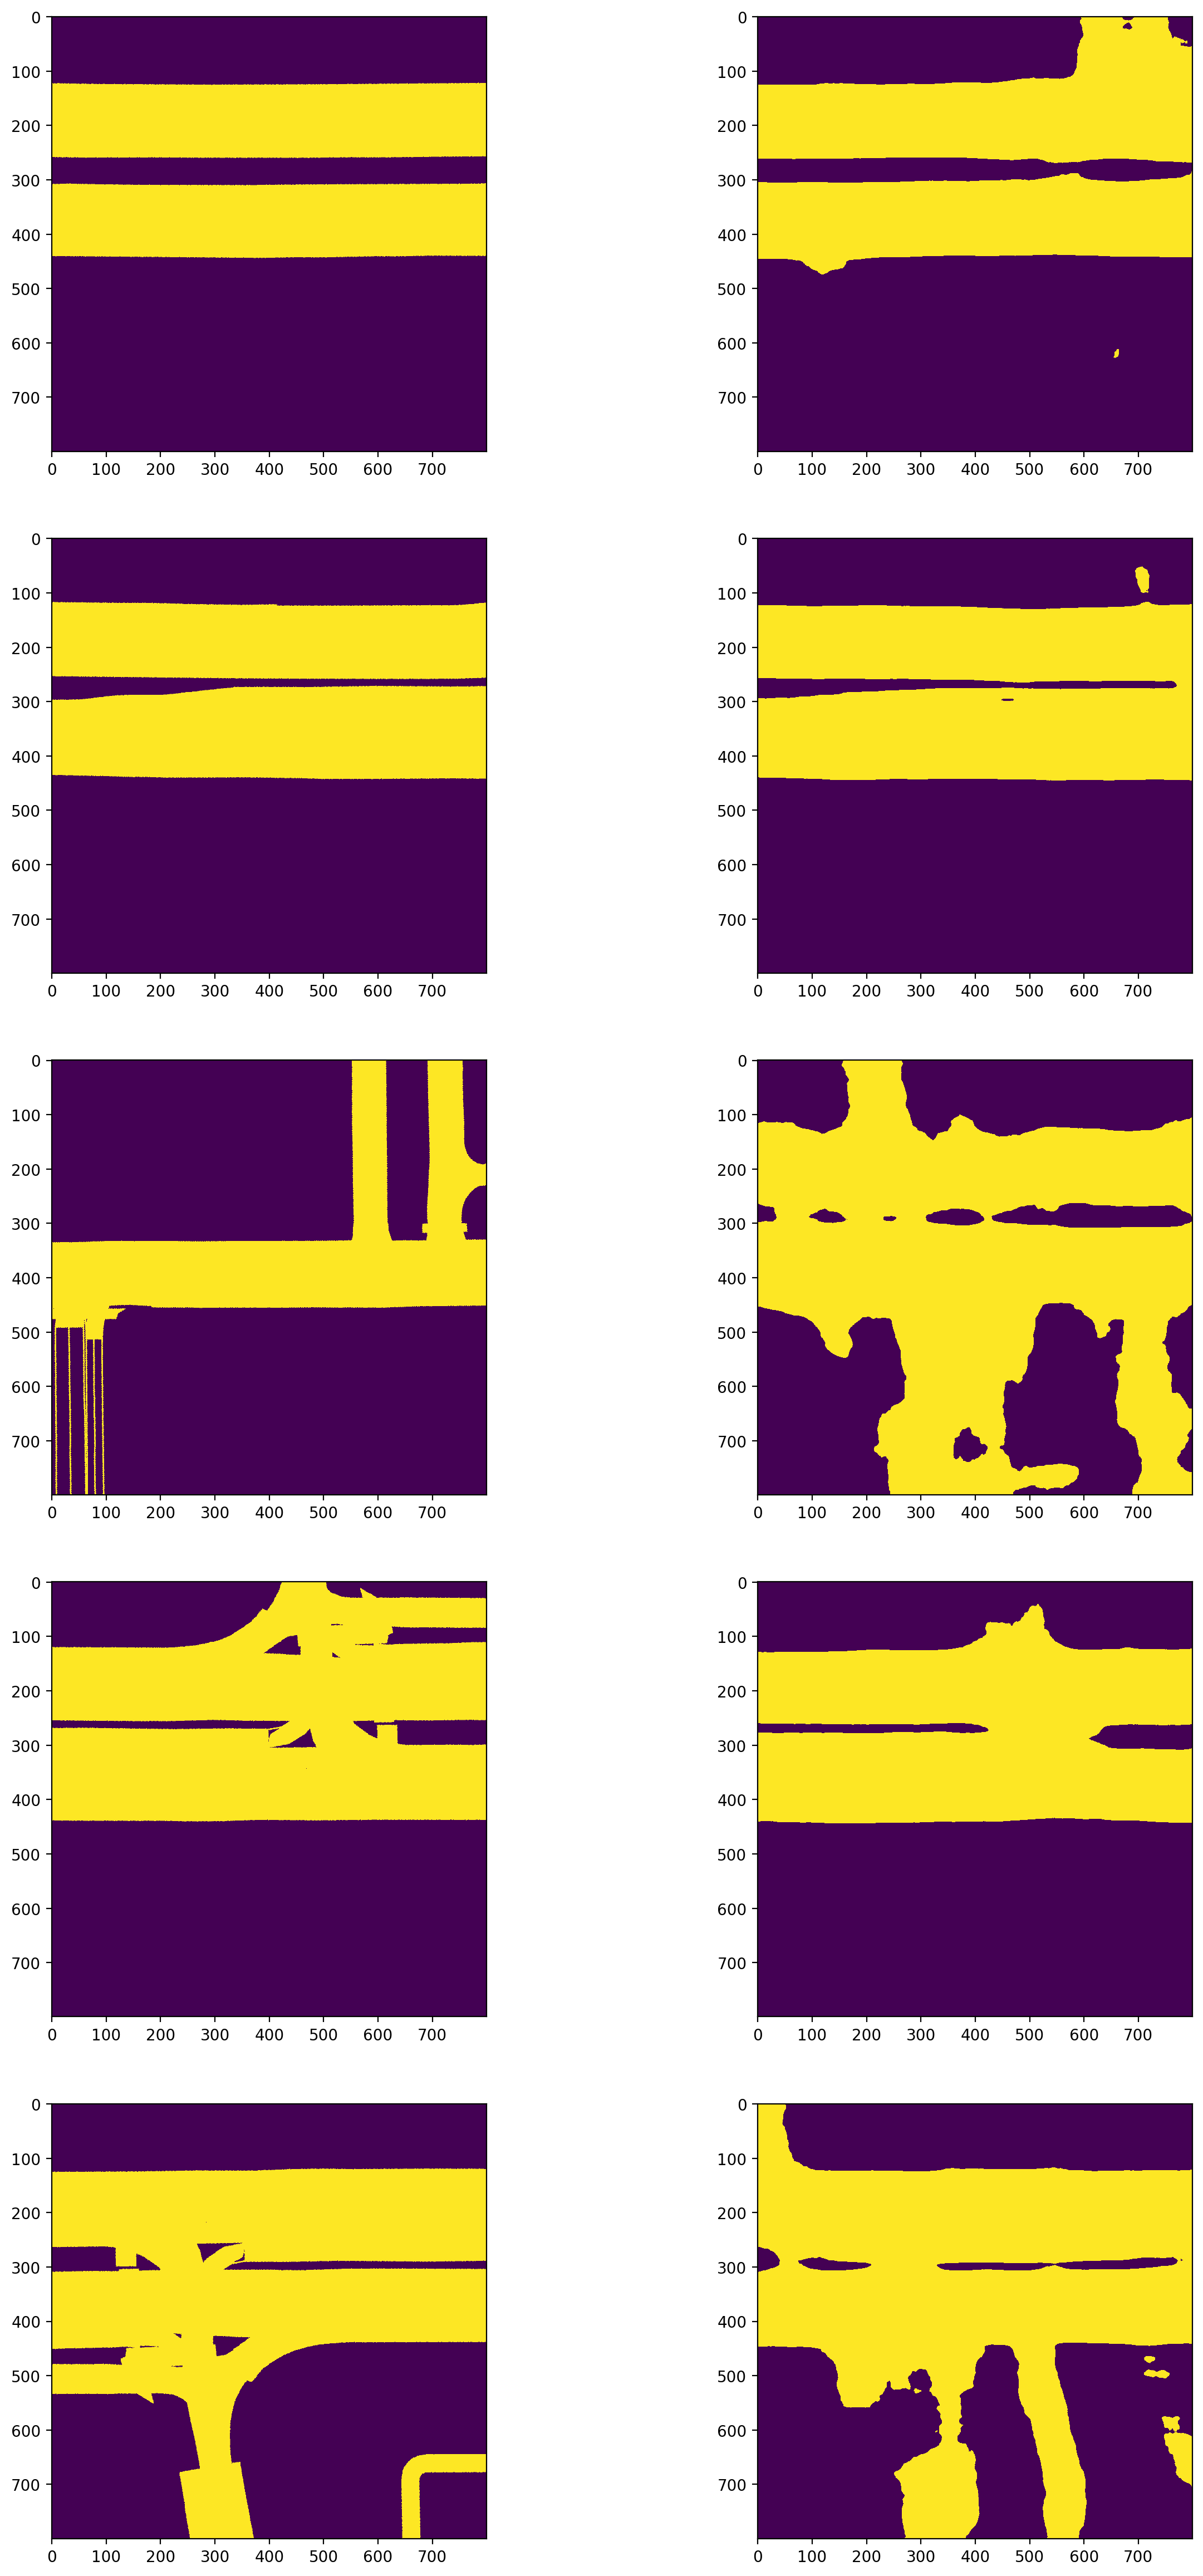

Epoch 2/10
----------
current epoch train dice loss is 174.199854
current epoch train dice coef is 1298.900269
training 1 epoch takes 426.297079
current epoch val dice loss is 103.808775
current epoch val dice coef is 200.095642
valing 1 epoch takes 459.762590
current ts is 0.683993
Epoch 3/10
----------
current epoch train dice loss is 152.708212
current epoch train dice coef is 1309.646240
training 1 epoch takes 478.498998
current epoch val dice loss is 95.582255
current epoch val dice coef is 204.208939
valing 1 epoch takes 511.806900
current ts is 0.707145
saving best model
Epoch 4/10
----------
current epoch train dice loss is 135.779578
current epoch train dice coef is 1318.112183
training 1 epoch takes 424.652190
current epoch val dice loss is 97.877068
current epoch val dice coef is 203.061508
valing 1 epoch takes 461.932891
current ts is 0.702681
Epoch 5/10
----------
current epoch train dice loss is 121.411733
current epoch train dice coef is 1325.294434
training 1 epoch take

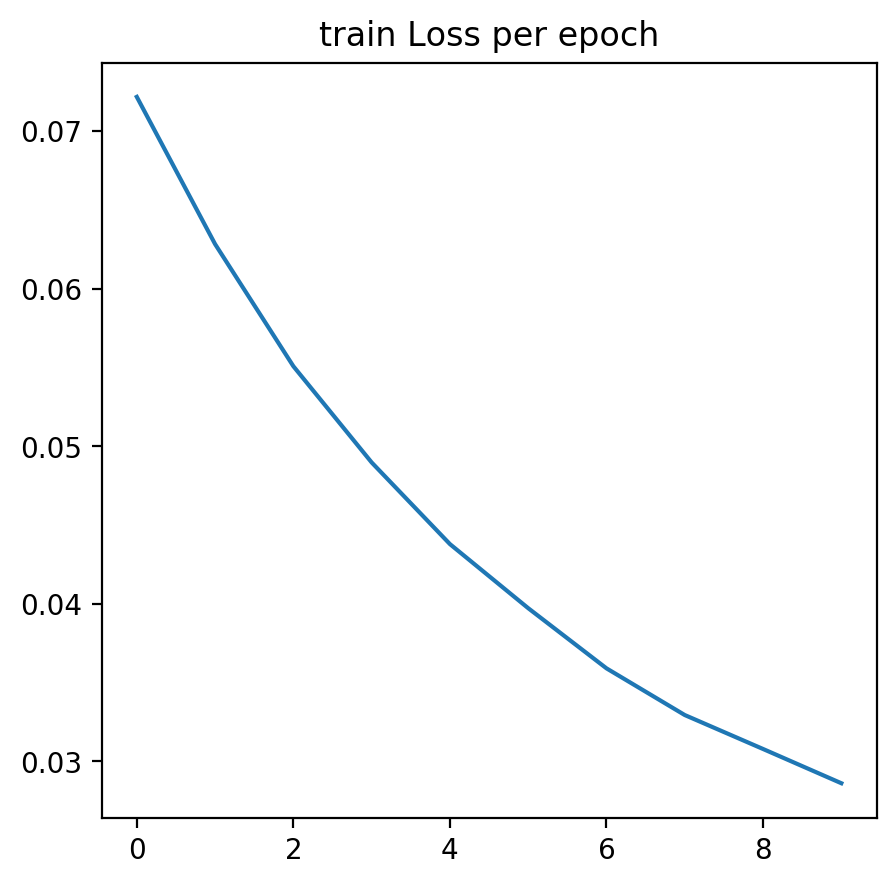

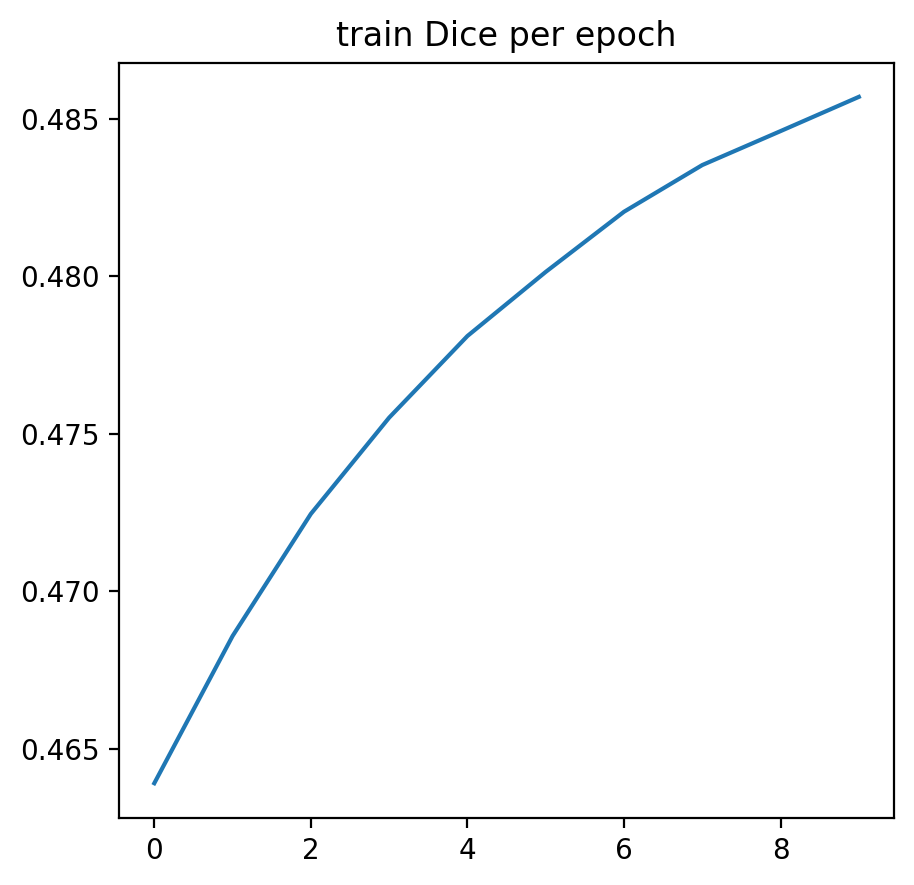

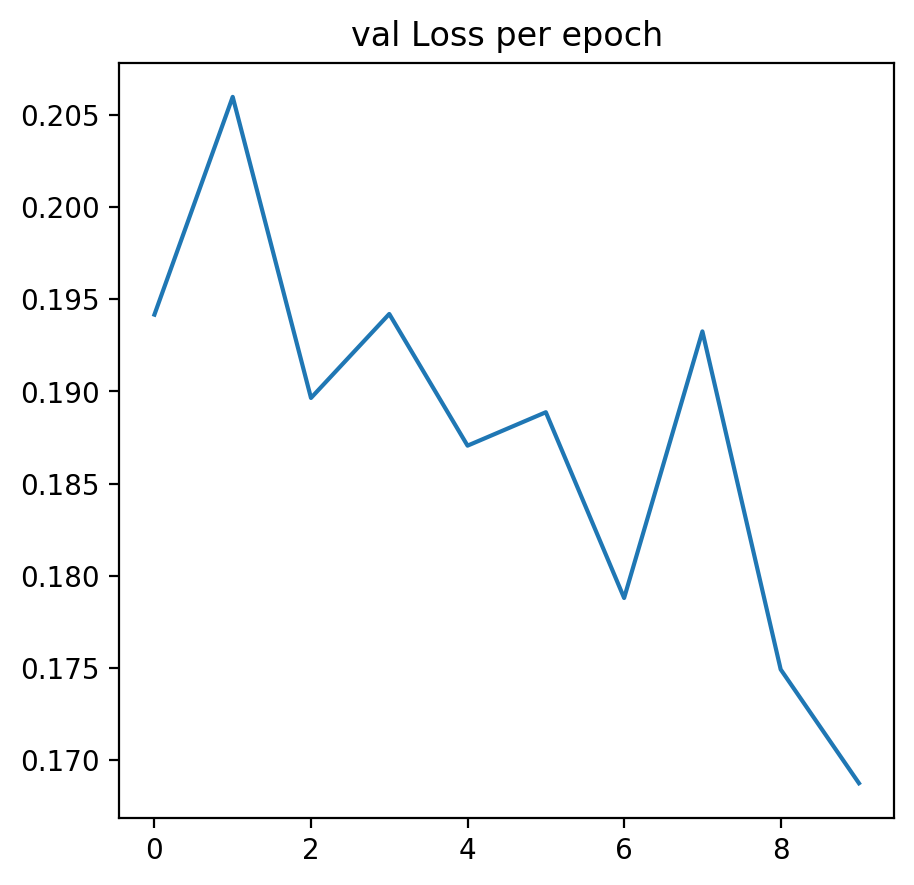

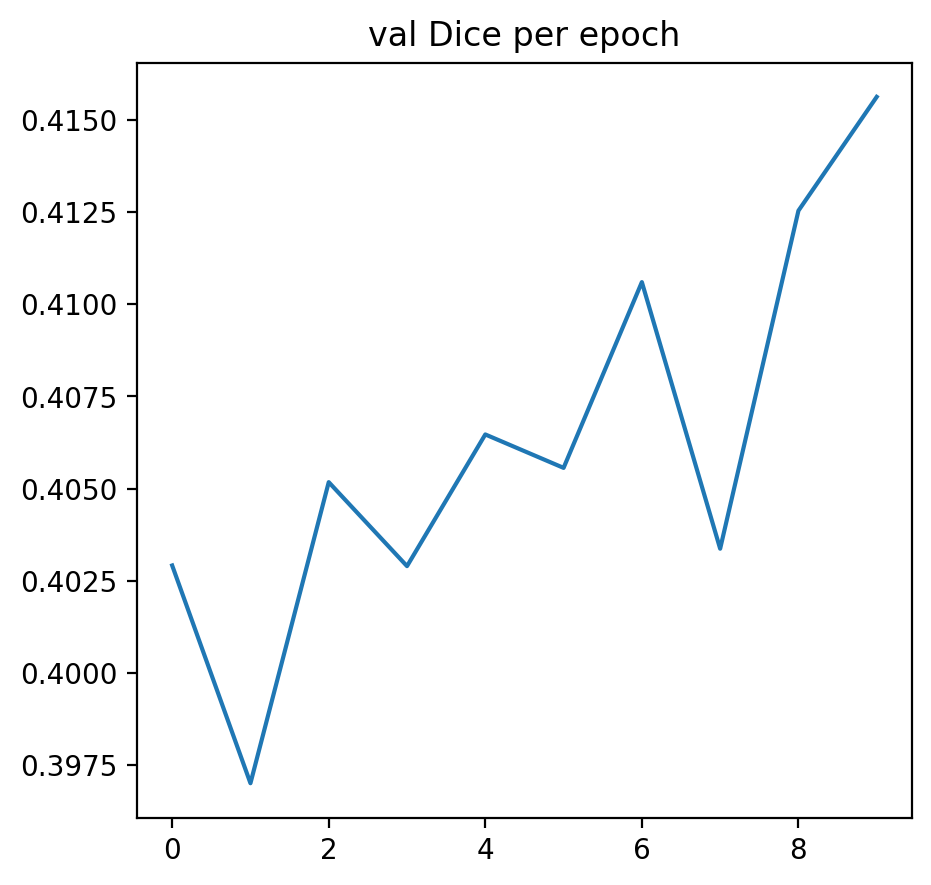

In [22]:
model1, loss_dict1, dice_dict1, ts_loss1, best_model_wts1 = train_eval_model(model1, 
                                                                 dataloaders, 
                                                                 dice_loss, 
                                                                 optimizer1, 
                                                                 num_epochs=10,
                                                                 checkpoint = '/scratch/ht1162/DLResult/supervised_train_res50.pth',
                                                                 to_save = '/scratch/ht1162/DLResult/supervised_train_res50.pth',           
                                                                 print_every=10,
                                                                 eval_every=1,
                                                                 to_eval=True)

In [12]:
# final average pool layer and last residual layer is removed to better preserve the resolutions
resnet_encoder1 = torchvision.models.resnet50(pretrained = False)
resnet_encoder1 = list(resnet_encoder1.children())[:-3]
resnet_encoder1 = nn.Sequential(*resnet_encoder1)
for param in resnet_encoder1.parameters():
    param.requires_grad = True
resnet_encoder1 = resnet_encoder1.to(device)

DIM1 = 16
DIM2 = 20
decoder1 = PPMBilinear(fc_dim=1024).to(device)
my_model1 = vpn_model(DIM1, DIM2, resnet_encoder1, decoder1).to(device)
optimizer1 = torch.optim.Adam(my_model1.parameters(), lr = 1e-4)
dataloaders = {'train': train_loader, 'val': val_loader}

In [13]:
import time

loading weights
Epoch 1/20
----------
current epoch train dice loss is 51.773833
current epoch train dice coef is 1360.111572
training 1 epoch takes 414.493374
current epoch val dice loss is 93.208743
current epoch val dice coef is 205.395676
valing 1 epoch takes 457.667905
current ts is 0.716398
printing test image


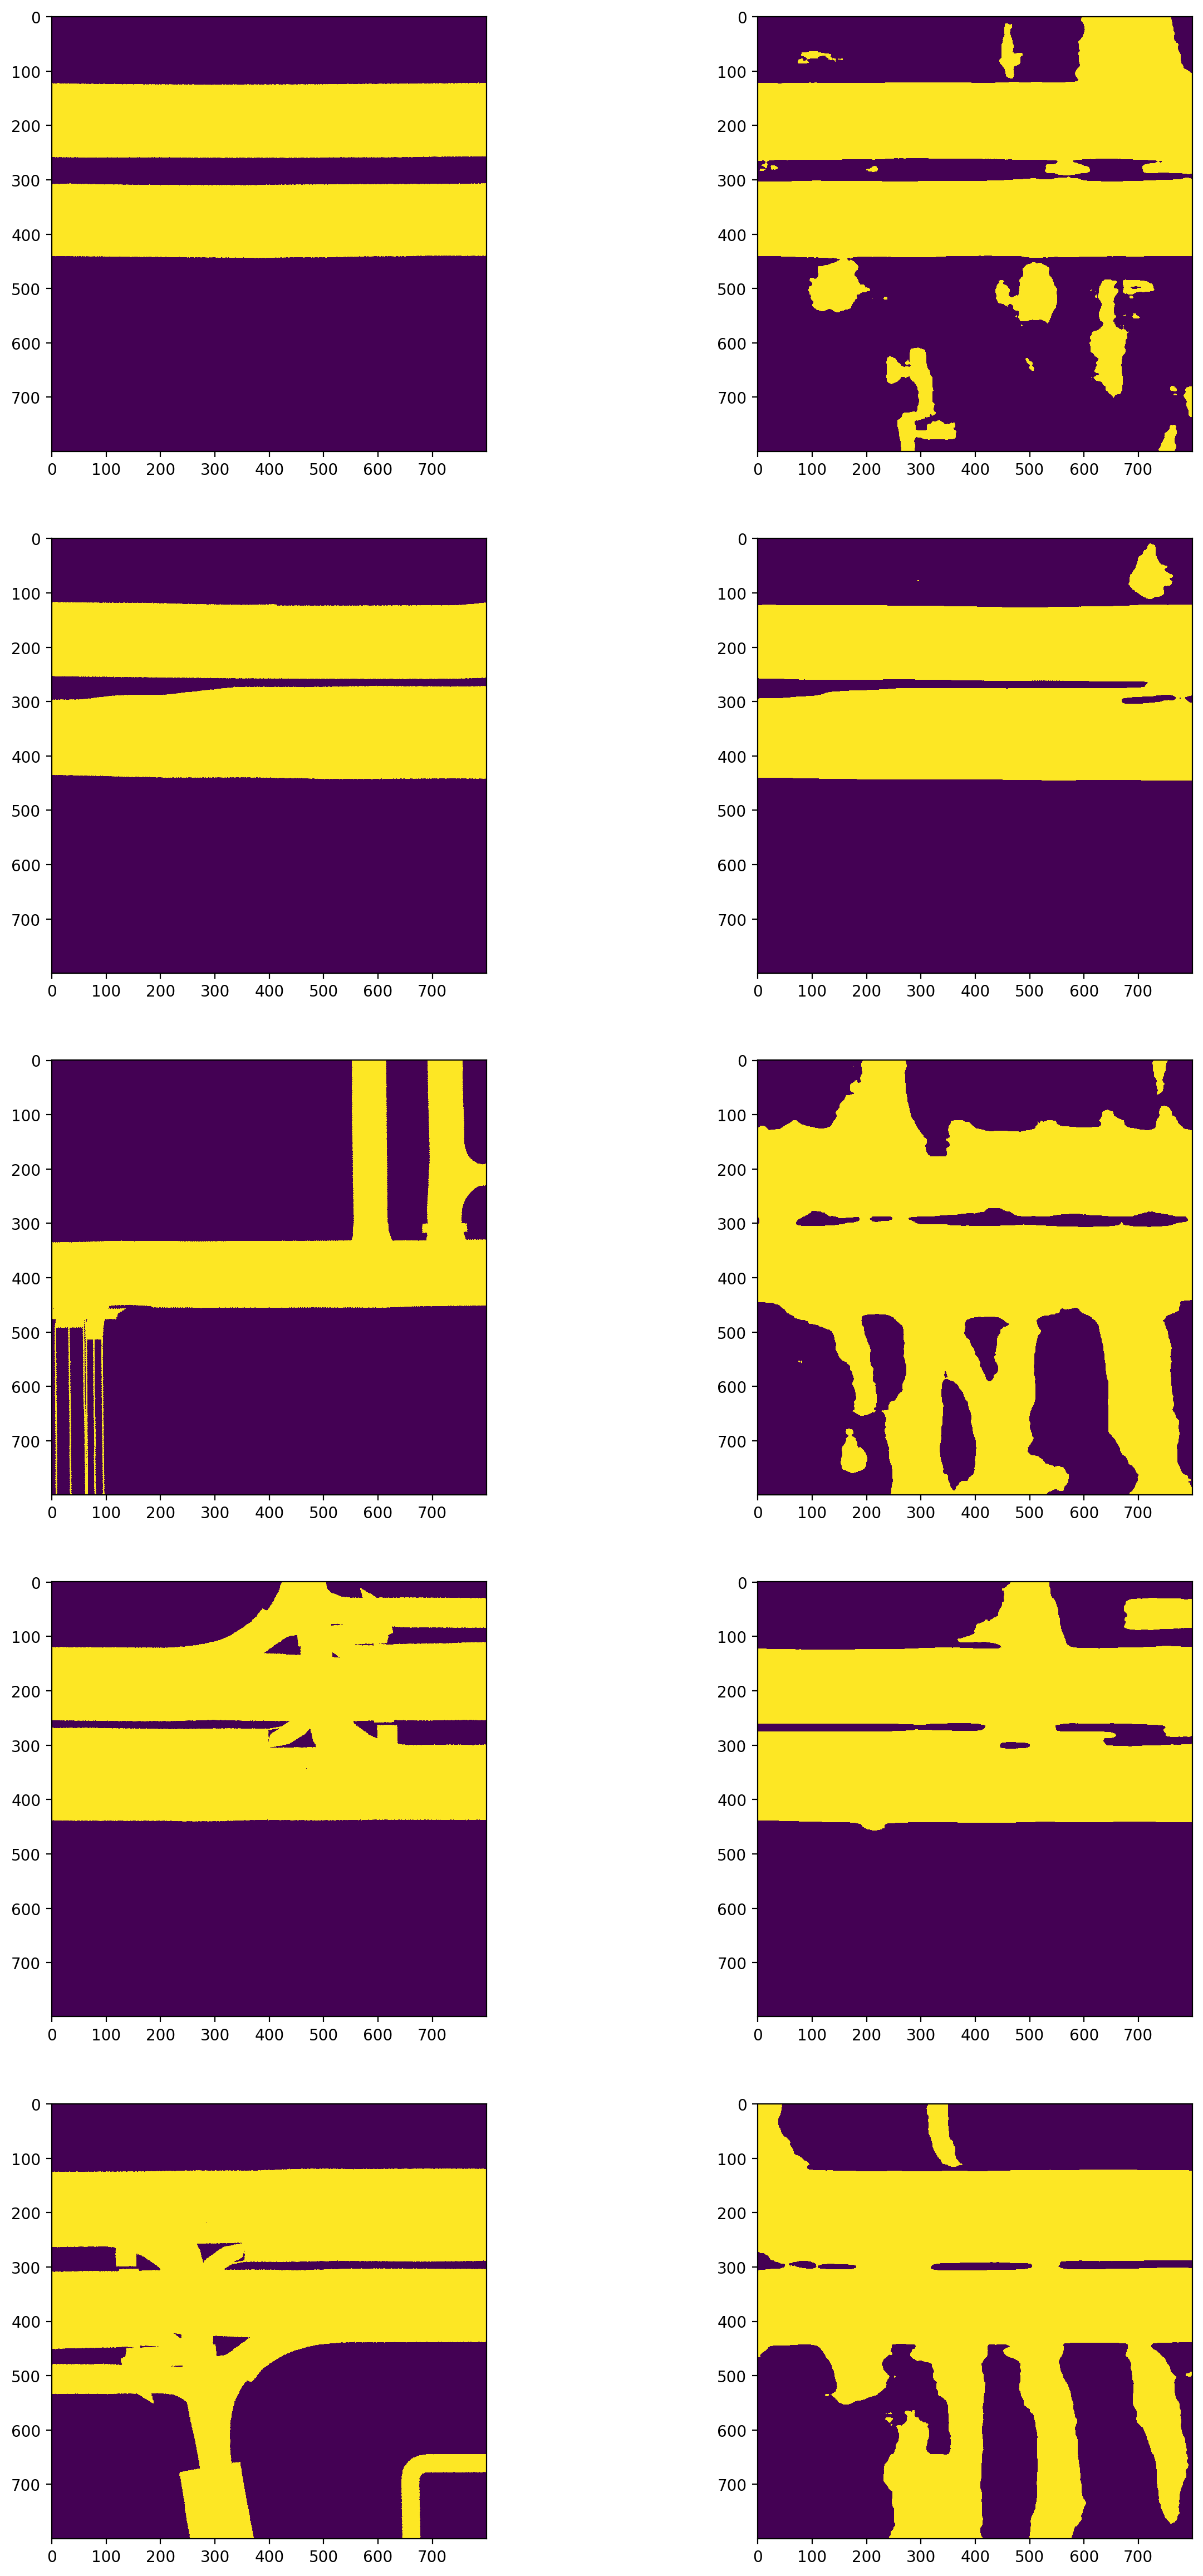

Epoch 2/20
----------
current epoch train dice loss is 50.541727
current epoch train dice coef is 1360.727783
training 1 epoch takes 460.840453
current epoch val dice loss is 82.861788
current epoch val dice coef is 210.569046
valing 1 epoch takes 496.625177
current ts is 0.747976
saving best model
Epoch 3/20
----------
current epoch train dice loss is 49.133058
current epoch train dice coef is 1361.433472
training 1 epoch takes 437.579987
current epoch val dice loss is 86.927714
current epoch val dice coef is 208.536179
valing 1 epoch takes 469.692773
current ts is 0.734498
Epoch 4/20
----------
current epoch train dice loss is 47.928922
current epoch train dice coef is 1362.036255
training 1 epoch takes 438.221056
current epoch val dice loss is 89.886209
current epoch val dice coef is 207.056824
valing 1 epoch takes 472.616440
current ts is 0.724911
Epoch 5/20
----------
current epoch train dice loss is 46.883758
current epoch train dice coef is 1362.556274
training 1 epoch takes 397

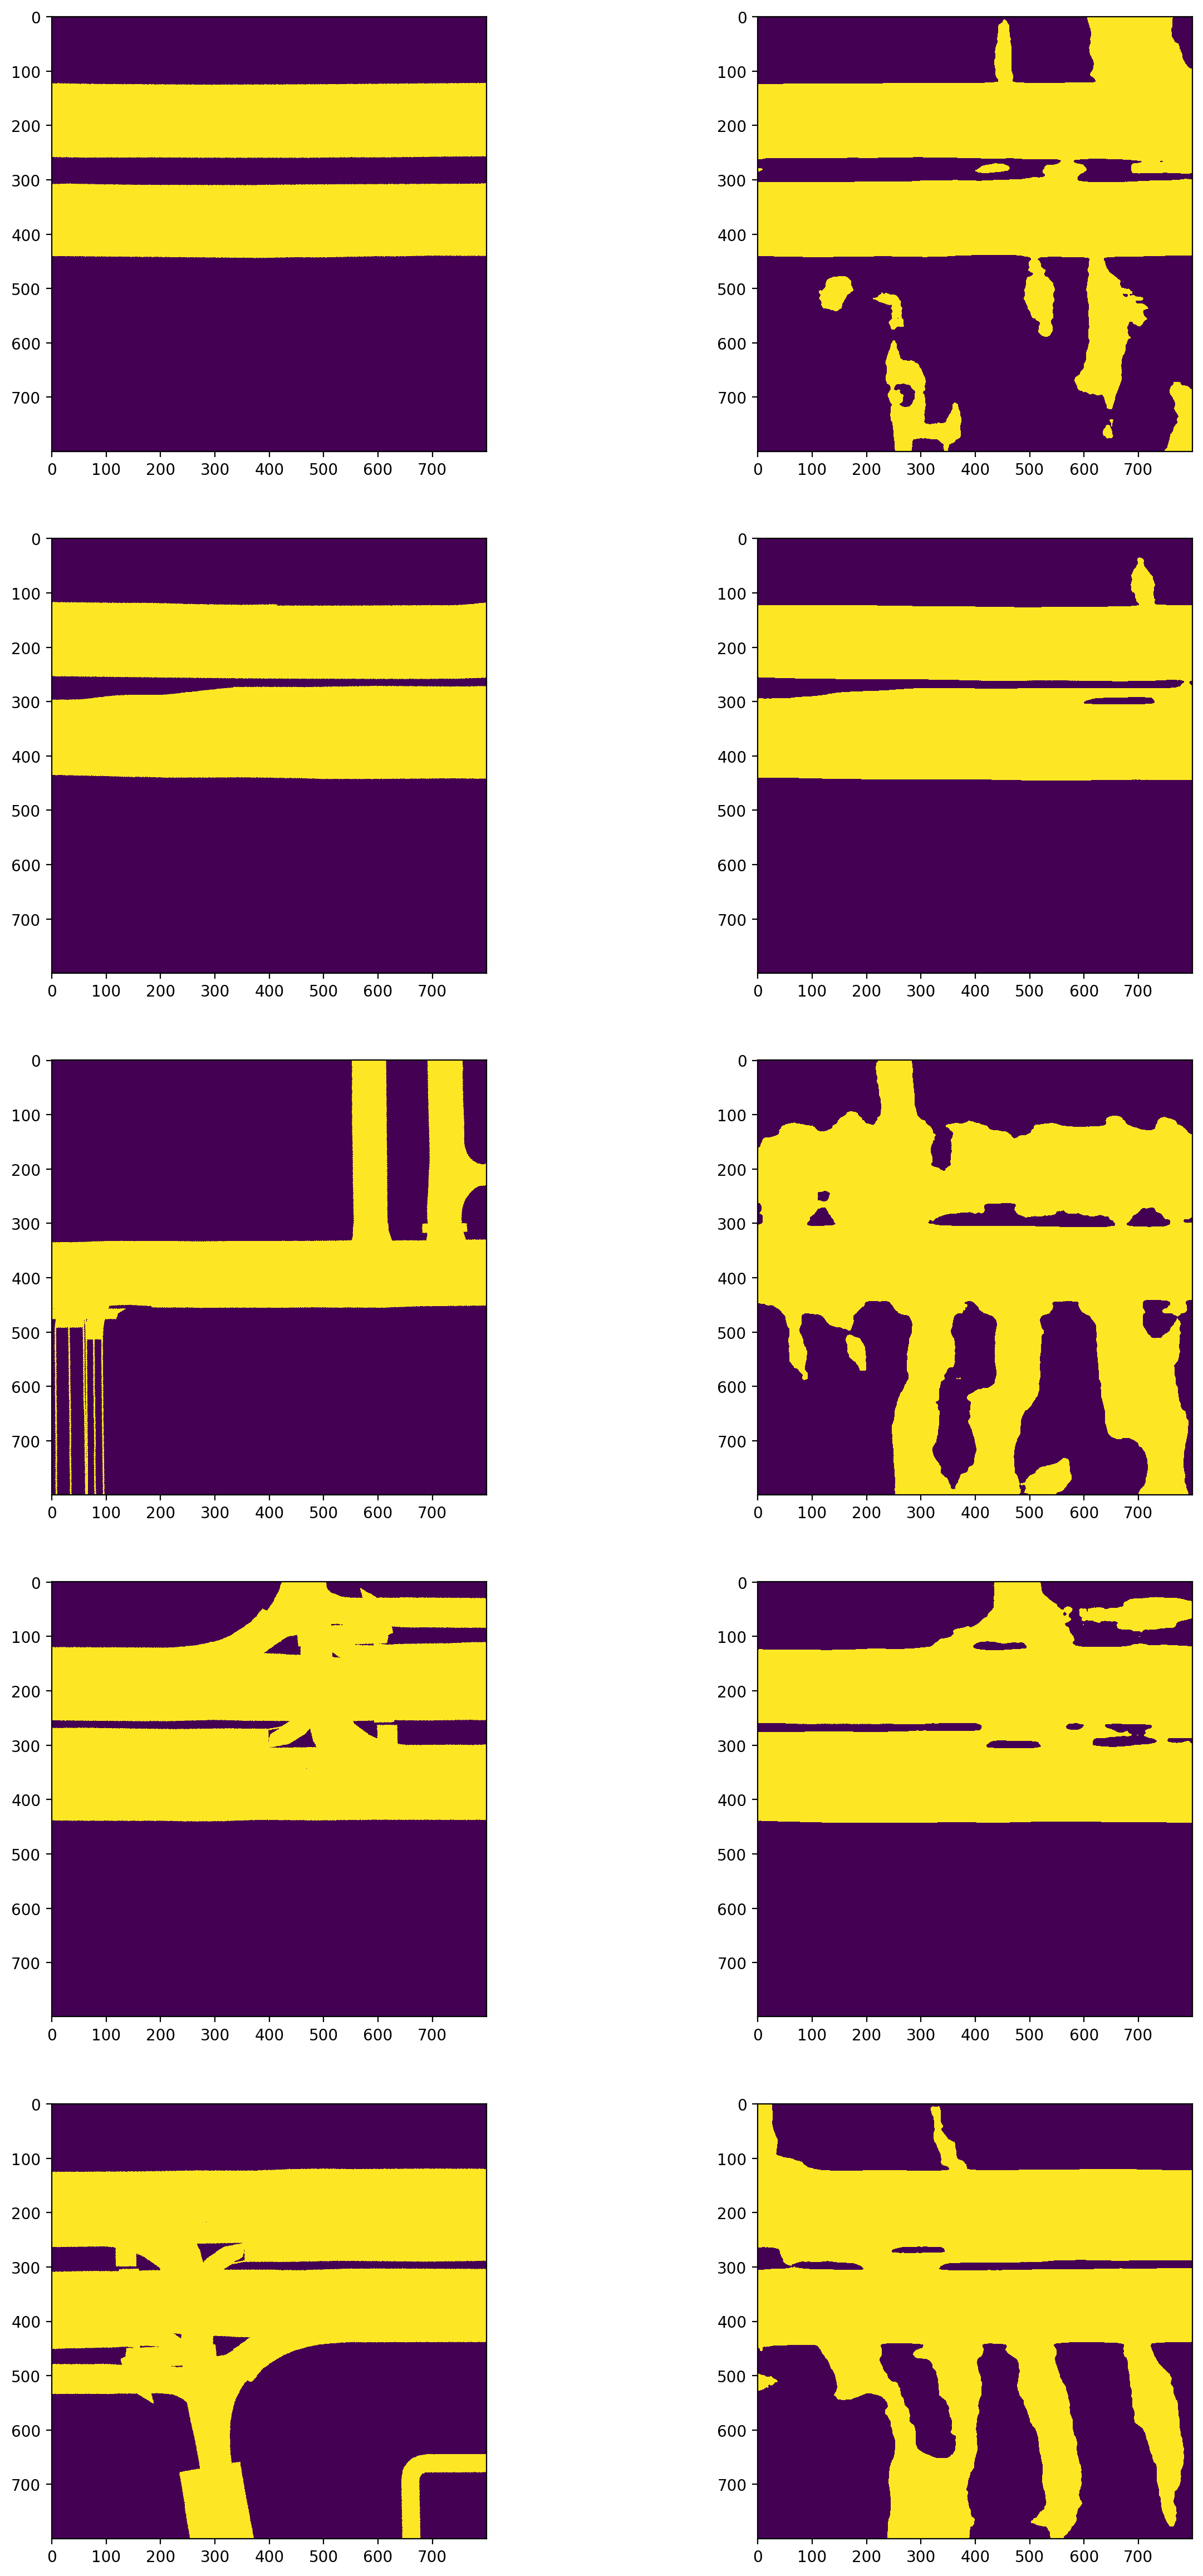

Epoch 12/20
----------
current epoch train dice loss is 41.201632
current epoch train dice coef is 1365.397949
training 1 epoch takes 472.192615
current epoch val dice loss is 83.471519
current epoch val dice coef is 210.264282
valing 1 epoch takes 503.462196
current ts is 0.745578
Epoch 13/20
----------
current epoch train dice loss is 40.682738
current epoch train dice coef is 1365.656372
training 1 epoch takes 370.926622
current epoch val dice loss is 85.521761
current epoch val dice coef is 209.239136
valing 1 epoch takes 402.408441
current ts is 0.739156
Epoch 14/20
----------
current epoch train dice loss is 39.909517
current epoch train dice coef is 1366.046997
training 1 epoch takes 416.196984
current epoch val dice loss is 91.212324
current epoch val dice coef is 206.393890
valing 1 epoch takes 446.016094
current ts is 0.721948
Epoch 15/20
----------
current epoch train dice loss is 39.494763
current epoch train dice coef is 1366.250732
training 1 epoch takes 431.568382
curren

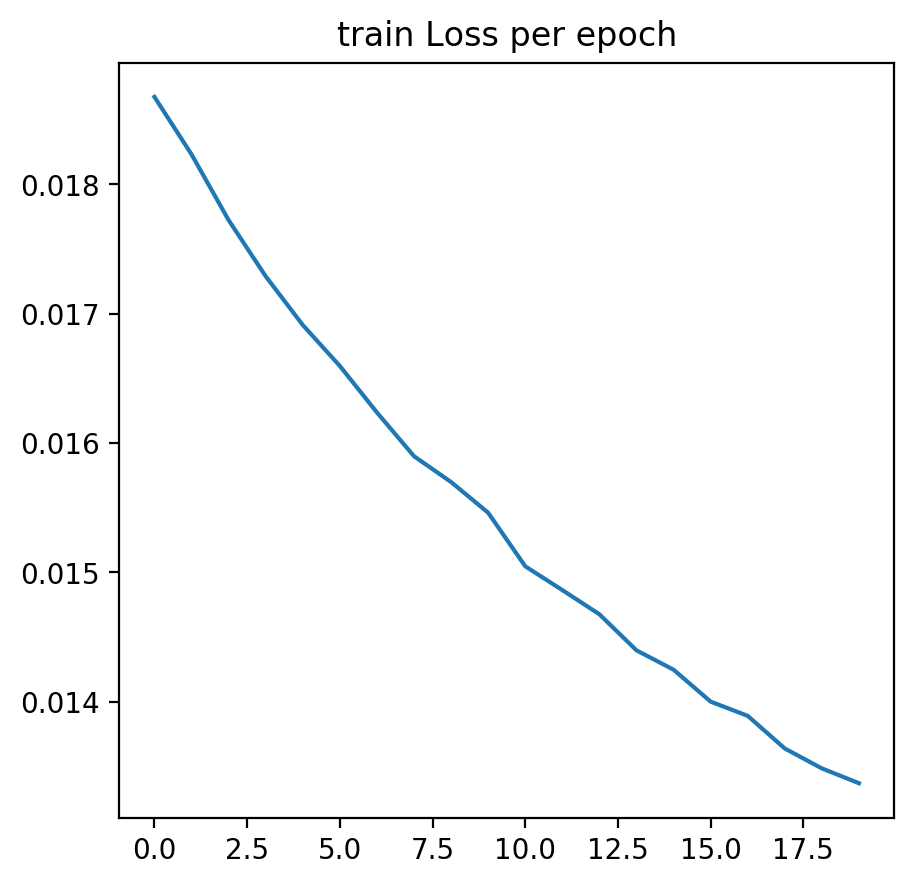

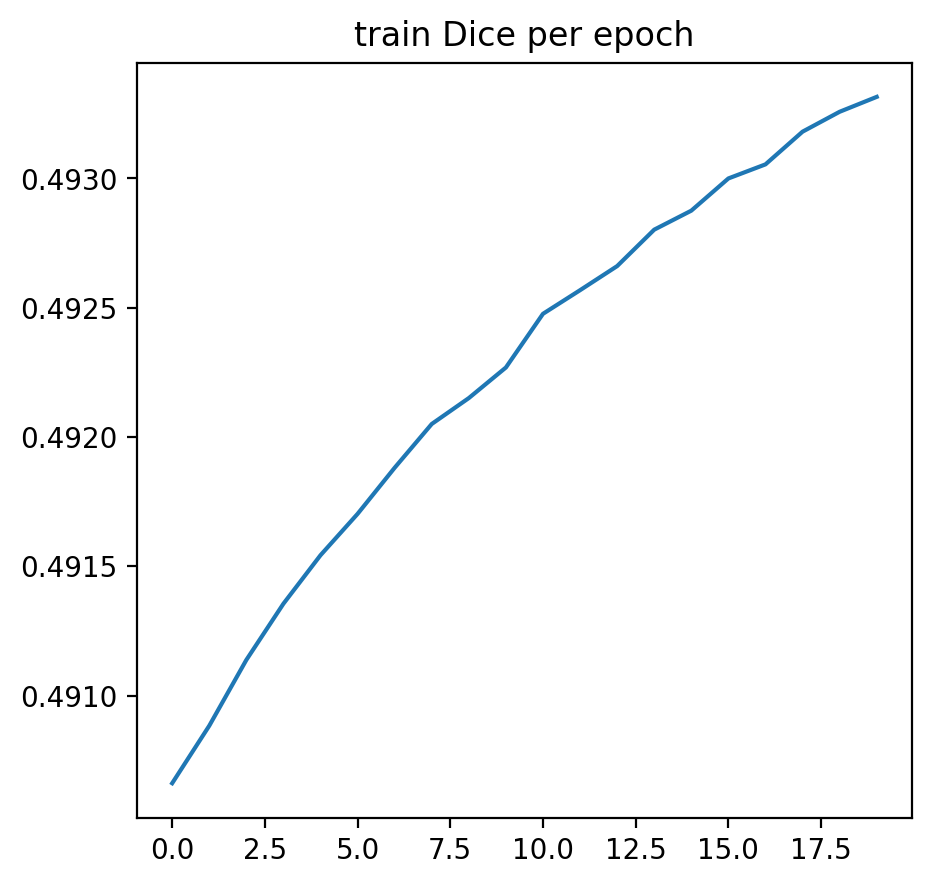

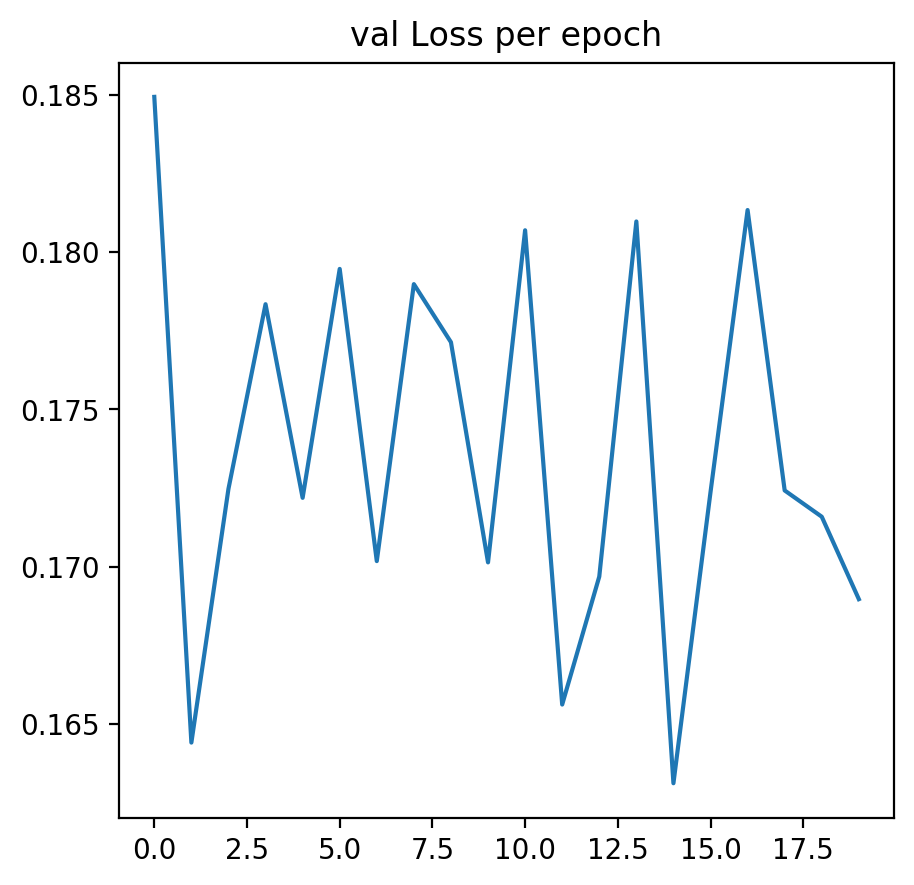

In [16]:
model1, loss_dict1, dice_dict1, ts_loss1, best_model_wts1 = train_eval_model(my_model1, 
                                                                 dataloaders, 
                                                                 dice_loss, 
                                                                 optimizer1, 
                                                                 num_epochs=20,
                                                                 checkpoint = '/scratch/ht1162/DLResult/supervised_train_res50.pth',
                                                                 to_save = '/scratch/ht1162/DLResult/supervised_train_res50.pth',           
                                                                 print_every=10,
                                                                 eval_every=1,
                                                                 to_eval=True)

In [18]:
resnet_encoder1 = torchvision.models.resnet50(pretrained = False)
resnet_encoder1 = list(resnet_encoder1.children())[:-3]
resnet_encoder1 = nn.Sequential(*resnet_encoder1)
for param in resnet_encoder1.parameters():
    param.requires_grad = True
resnet_encoder1 = resnet_encoder1.to(device)

DIM1 = 16
DIM2 = 20
decoder1 = PPMBilinear(fc_dim=1024).to(device)
my_model = vpn_model(DIM1, DIM2, resnet_encoder1, decoder1).to(device)


In [19]:
pt = torch.load('/scratch/ht1162/DLResult/supervised_train_res50.pth')
my_model.load_state_dict(pt['best_model'])

<All keys matched successfully>

In [23]:
print('printing test image')
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [432, 192, 319, 272, 69]
for fig_i, i in enumerate(test_idx):
    inputs = val_set[i][0].unsqueeze(0).to(device)

    outputs = my_model(inputs).cpu().squeeze().detach()

    ax[fig_i, 0].imshow(val_set[i][2].cpu().numpy())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())
plt.savefig('/scratch/ht1162/DLResult/resnet50_supervised_result.png')
plt.show()

printing test image


## The following trained a resnet18 with STN to see whether it really works